This notebook contains the code to replicate figure 1. 
Figure 1 shows that 'useful information' transmitted within transcriptional regulatory network (TRN) decreases at the single-cell level. We apply noisy channel coding theorem to understand this.

In [2]:
# import packages

import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import entropy
from math import log, e

Tabula Muris Senis gene counts data FACS - smartseq2 data

In [5]:
### RAW DATA FOR METADATA 

# #homePC
# results_file ='C:/Users/Sruthi Sivakumar/OneDrive - University of Pittsburgh/PhD proposal/Noisy channel research/files_from_box/tabula-muris-senis-facs-processed-official-annotations-Limb_Muscle.h5ad'
# # #results_file ='C:/Users/Sruthi Sivakumar/Box/Pitt/Tabula Muris senis- for proposal/processed h5ad files-figshare/tabula-muris-senis-facs-processed-official-annotations-Limb_Muscle.h5ad'

#labPC
results_file ='D:/OneDrive - University of Pittsburgh/PhD proposal/Noisy channel research/files_from_box/tabula-muris-senis-facs-processed-official-annotations-Limb_Muscle.h5ad'

adata = sc.read_h5ad(results_file)

### TMS single FACS data - clean gene counts data
### male and female mixed
### eliminated genes - which did not satisfy: expressed non-zero value in minimum of 10 cells 
### This is so that we consider genes that are expressed in a variety of cells

# #HOMEpc
# file='C:/Users/Sruthi Sivakumar/OneDrive - University of Pittsburgh/PhD proposal/Noisy channel research/nonzero_10cutoff_facscountmatrix8dec.csv'

#labPC
file='D:/OneDrive - University of Pittsburgh/PhD proposal/Noisy channel research/nonzero_10cutoff_facscountmatrix8dec.csv'

adata_facs_df= pd.read_csv(file,index_col=0)

Transcriptional regulatory network edgelist from TRRUST database

In [7]:
# #homePC
# alltfdf=pd.read_csv("C:/Users/Sruthi Sivakumar/OneDrive - University of Pittsburgh/PhD proposal/Noisy channel research/files_from_box/trrust_rawdata.mouse_wheader.csv")

#labPC
alltfdf=pd.read_csv("D:/OneDrive - University of Pittsburgh/PhD proposal/Noisy channel research/files_from_box/trrust_rawdata.mouse_wheader.csv")


Overview of dataset

In [13]:
# raw single cell data - number of genes
print("Raw data number of genes", adata.var.shape)

# clean single cell data - number of genes
print("Clean data number of genes", adata_facs_df.shape)
adata_facs_df.head()

Raw data number of genes (22966, 5)
Clean data number of genes (3855, 10837)


0610007C21Rik  0610007L01Rik  0610007N19Rik  0610007P08Rik  \
18m            0.0       0.000000            0.0            0.0   
18m            0.0       0.000000            0.0            0.0   
18m            0.0       0.072408            0.0            0.0   
18m            0.0       0.000000            0.0            0.0   
18m            0.0       0.000000            0.0            0.0   

     0610007P14Rik  0610007P22Rik  0610009B22Rik  0610009D07Rik  \
18m            0.0            0.0       0.334001       0.037076   
18m            0.0            0.0       0.000000       2.299186   
18m            0.0            0.0       0.000000       2.137391   
18m            0.0            0.0       0.000000       0.000000   
18m            0.0            0.0       0.000000       0.000000   

     0610009L18Rik  0610009O20Rik  ...  Zufsp  Zw10     Zwint      Zxdc  \
18m            0.0            0.0  ...    0.0   0.0  0.000000  0.000000   
18m            0.0            0.0  ...    0.0   0.0  0.000000  6.599676   
18m            0.0            0.0  ...    0.0   0.0  0.038261  0.046321   
18m            0.0            0.0  ...    0.0   0.0  0.000000  0.000000   
18m            0.0            0.0  ...    0.0   0.0  0.000000  0.000000   

      Zyg11b       Zyx     Zzef1      Zzz3  age  \
18m  0.04276  0.000000  0.000000  0.153797  18m   
18m  0.00000  2.941003  0.000000  0.000000  18m   
18m  0.00000  2.052351  0.000000  0.000000  18m   
18m  0.00000  0.140650  0.000000  0.000000  18m   
18m  0.00000  0.599470  0.053462  0.000000  18m   

                           celltype  
18m  skeletal muscle satellite cell  
18m  skeletal muscle satellite cell  
18m  skeletal muscle satellite cell  
18m  skeletal muscle satellite cell  
18m  skeletal muscle satellite cell  

[5 rows x 10837 columns]

In [14]:
adata_facs_df['age'].value_counts()

18m    1521
24m    1232
3m     1102
Name: age, dtype: int64

In [15]:
adata.obs['age'].value_counts()

18m    1521
24m    1232
3m     1102
Name: age, dtype: int64

In [16]:
adata.obs['mouse.id'].unique()

['18_46_F', '18_47_F', '18_45_M', '18_53_M', '24_59_M', ..., '3_11_M', '3_8_M', '3_39_F', '3_10_M', '3_9_M']
Length: 14
Categories (14, object): ['18_46_F', '18_47_F', '18_45_M', '18_53_M', ..., '3_8_M', '3_39_F', '3_10_M', '3_9_M']

In [17]:
sc_facs=adata_facs_df

sc_facs.index=list(adata.obs.index.values)
#sc_facs.columns=list(adata.var.index.values)

sc_facs['age']=list(adata.obs.age)
sc_facs['animal_id']=list(adata.obs['mouse.id'])
sc_facs['celltype']=list(adata.obs.cell_ontology_class)
sc_facs['sex']=list(adata.obs.sex)

In [18]:
age3m_df=sc_facs[sc_facs['age']=='3m']
age18m_df=sc_facs[sc_facs['age']=='18m']
age24m_df=sc_facs[sc_facs['age']=='24m']

In [19]:
unique_dict={}
test_list=dict(zip(list(alltfdf['TF genes']),list(alltfdf['Non-TF genes'])))
for item in test_list.items():
    if item not in unique_dict:
        unique_dict.update({item})
    

len(unique_dict) 

827

In [21]:
age3m_df.head()

0610007C21Rik  0610007L01Rik  0610007N19Rik  \
A1.B002765.3_38_F.1.1-1-1        1.761105       1.541098            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       1.788955            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       3.050025            0.0   
A10.B002769.3_39_F.1.1-1-1       1.564775       0.000000            0.0   

                            0610007P08Rik  0610007P14Rik  0610007P22Rik  \
A1.B002765.3_38_F.1.1-1-1             0.0            0.0            0.0   
A1.D042103.3_11_M.1-1-1               0.0            0.0            0.0   
A1.D042186.3_8_M.1.1-1-1              0.0            0.0            0.0   
A10.B002765.3_38_F.1.1-1-1            0.0            0.0            0.0   
A10.B002769.3_39_F.1.1-1-1            0.0            0.0            0.0   

                            0610009B22Rik  0610009D07Rik  0610009L18Rik  \
A1.B002765.3_38_F.1.1-1-1        0.000000       0.000000            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       0.384158            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       1.533476            0.0   
A10.B002769.3_39_F.1.1-1-1       2.696855       0.817633            0.0   

                            0610009O20Rik  ...     Zwint  Zxdc    Zyg11b  \
A1.B002765.3_38_F.1.1-1-1        0.000000  ...  1.522642   0.0  0.000000   
A1.D042103.3_11_M.1-1-1          0.000000  ...  0.000000   0.0  0.000000   
A1.D042186.3_8_M.1.1-1-1         0.000000  ...  0.000000   0.0  0.161871   
A10.B002765.3_38_F.1.1-1-1       0.000000  ...  0.025267   0.0  0.000000   
A10.B002769.3_39_F.1.1-1-1       1.073734  ...  0.000000   0.0  0.029860   

                                 Zyx     Zzef1      Zzz3  age  \
A1.B002765.3_38_F.1.1-1-1   1.806709  0.000000  0.000000   3m   
A1.D042103.3_11_M.1-1-1     0.000000  0.000000  0.000000   3m   
A1.D042186.3_8_M.1.1-1-1    1.352870  1.701163  0.289918   3m   
A10.B002765.3_38_F.1.1-1-1  0.000000  0.000000  0.000000   3m   
A10.B002769.3_39_F.1.1-1-1  0.719527  0.024443  0.000000   3m   

                                                  celltype  animal_id     sex  
A1.B002765.3_38_F.1.1-1-1   skeletal muscle satellite cell     3_38_F  female  
A1.D042103.3_11_M.1-1-1     skeletal muscle satellite cell     3_11_M    male  
A1.D042186.3_8_M.1.1-1-1    skeletal muscle satellite cell      3_8_M    male  
A10.B002765.3_38_F.1.1-1-1  skeletal muscle satellite cell     3_38_F  female  
A10.B002769.3_39_F.1.1-1-1  skeletal muscle satellite cell     3_39_F  female  

[5 rows x 10839 columns]

# Figure 1A and 1B: Finding entropy after calculating mean expression of all cells 

First, we plot mean gene counts per cell to see the overall gene expression trend with age. This is the conventional bioinformatics approach.

Then, we want to quantify the total information content of genes across age. Shannon entropy quantifies the uncertainty in gene expression.


#extra information


This will help us compare entropy obtained from bulk RNA seq data (TMS) throughout the lifespan of mice. We observed an increase in entropy with bulk RNA seq data as well. We had this in supplemental. But since the trend was the same, it did not add anything new to the story.

C:\Users\sruth\Box\Sruthi.RNA-seq\shannon_entropy_Tim_17jun

    Original location for sarcopenia bulk RNA seq data

In [22]:
from scipy.stats import entropy


In [23]:
age3m = age3m_df.drop(['age','celltype'], axis=1)
age3m_mean= age3m.mean(axis = 0, skipna = True)
age3m_mean_animal=age3m.groupby('animal_id').mean()
age3m= age3m.sum(axis = 0, skipna = True)


In [24]:
age18m = age18m_df.drop(['age','celltype'], axis=1)
age18m_mean= age18m_df.mean(axis = 0, skipna = True)
age18m_mean_animal=age18m.groupby('animal_id').mean()
age18m= age18m.sum(axis = 0, skipna = True)


In [25]:
age24m = age24m_df.drop(['age','celltype'], axis=1)
age24m_mean= age24m.mean(axis = 0, skipna = True)
age24m_mean_animal=age24m.groupby('animal_id').mean()
age24m= age24m.sum(axis = 0, skipna = True)


# Figure 1A

Plotting mean gene count values (calculated across cells) for each age group.

In [26]:
age3m_mean

0610007C21Rik    0.562583
0610007L01Rik    0.616423
0610007N19Rik    0.261602
0610007P08Rik    0.241204
0610007P14Rik    0.271822
                   ...   
Zxdc             0.270104
Zyg11b           0.349982
Zyx              0.711595
Zzef1            0.304026
Zzz3             0.398686
Length: 10835, dtype: float64

C:\Users\SRS204\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


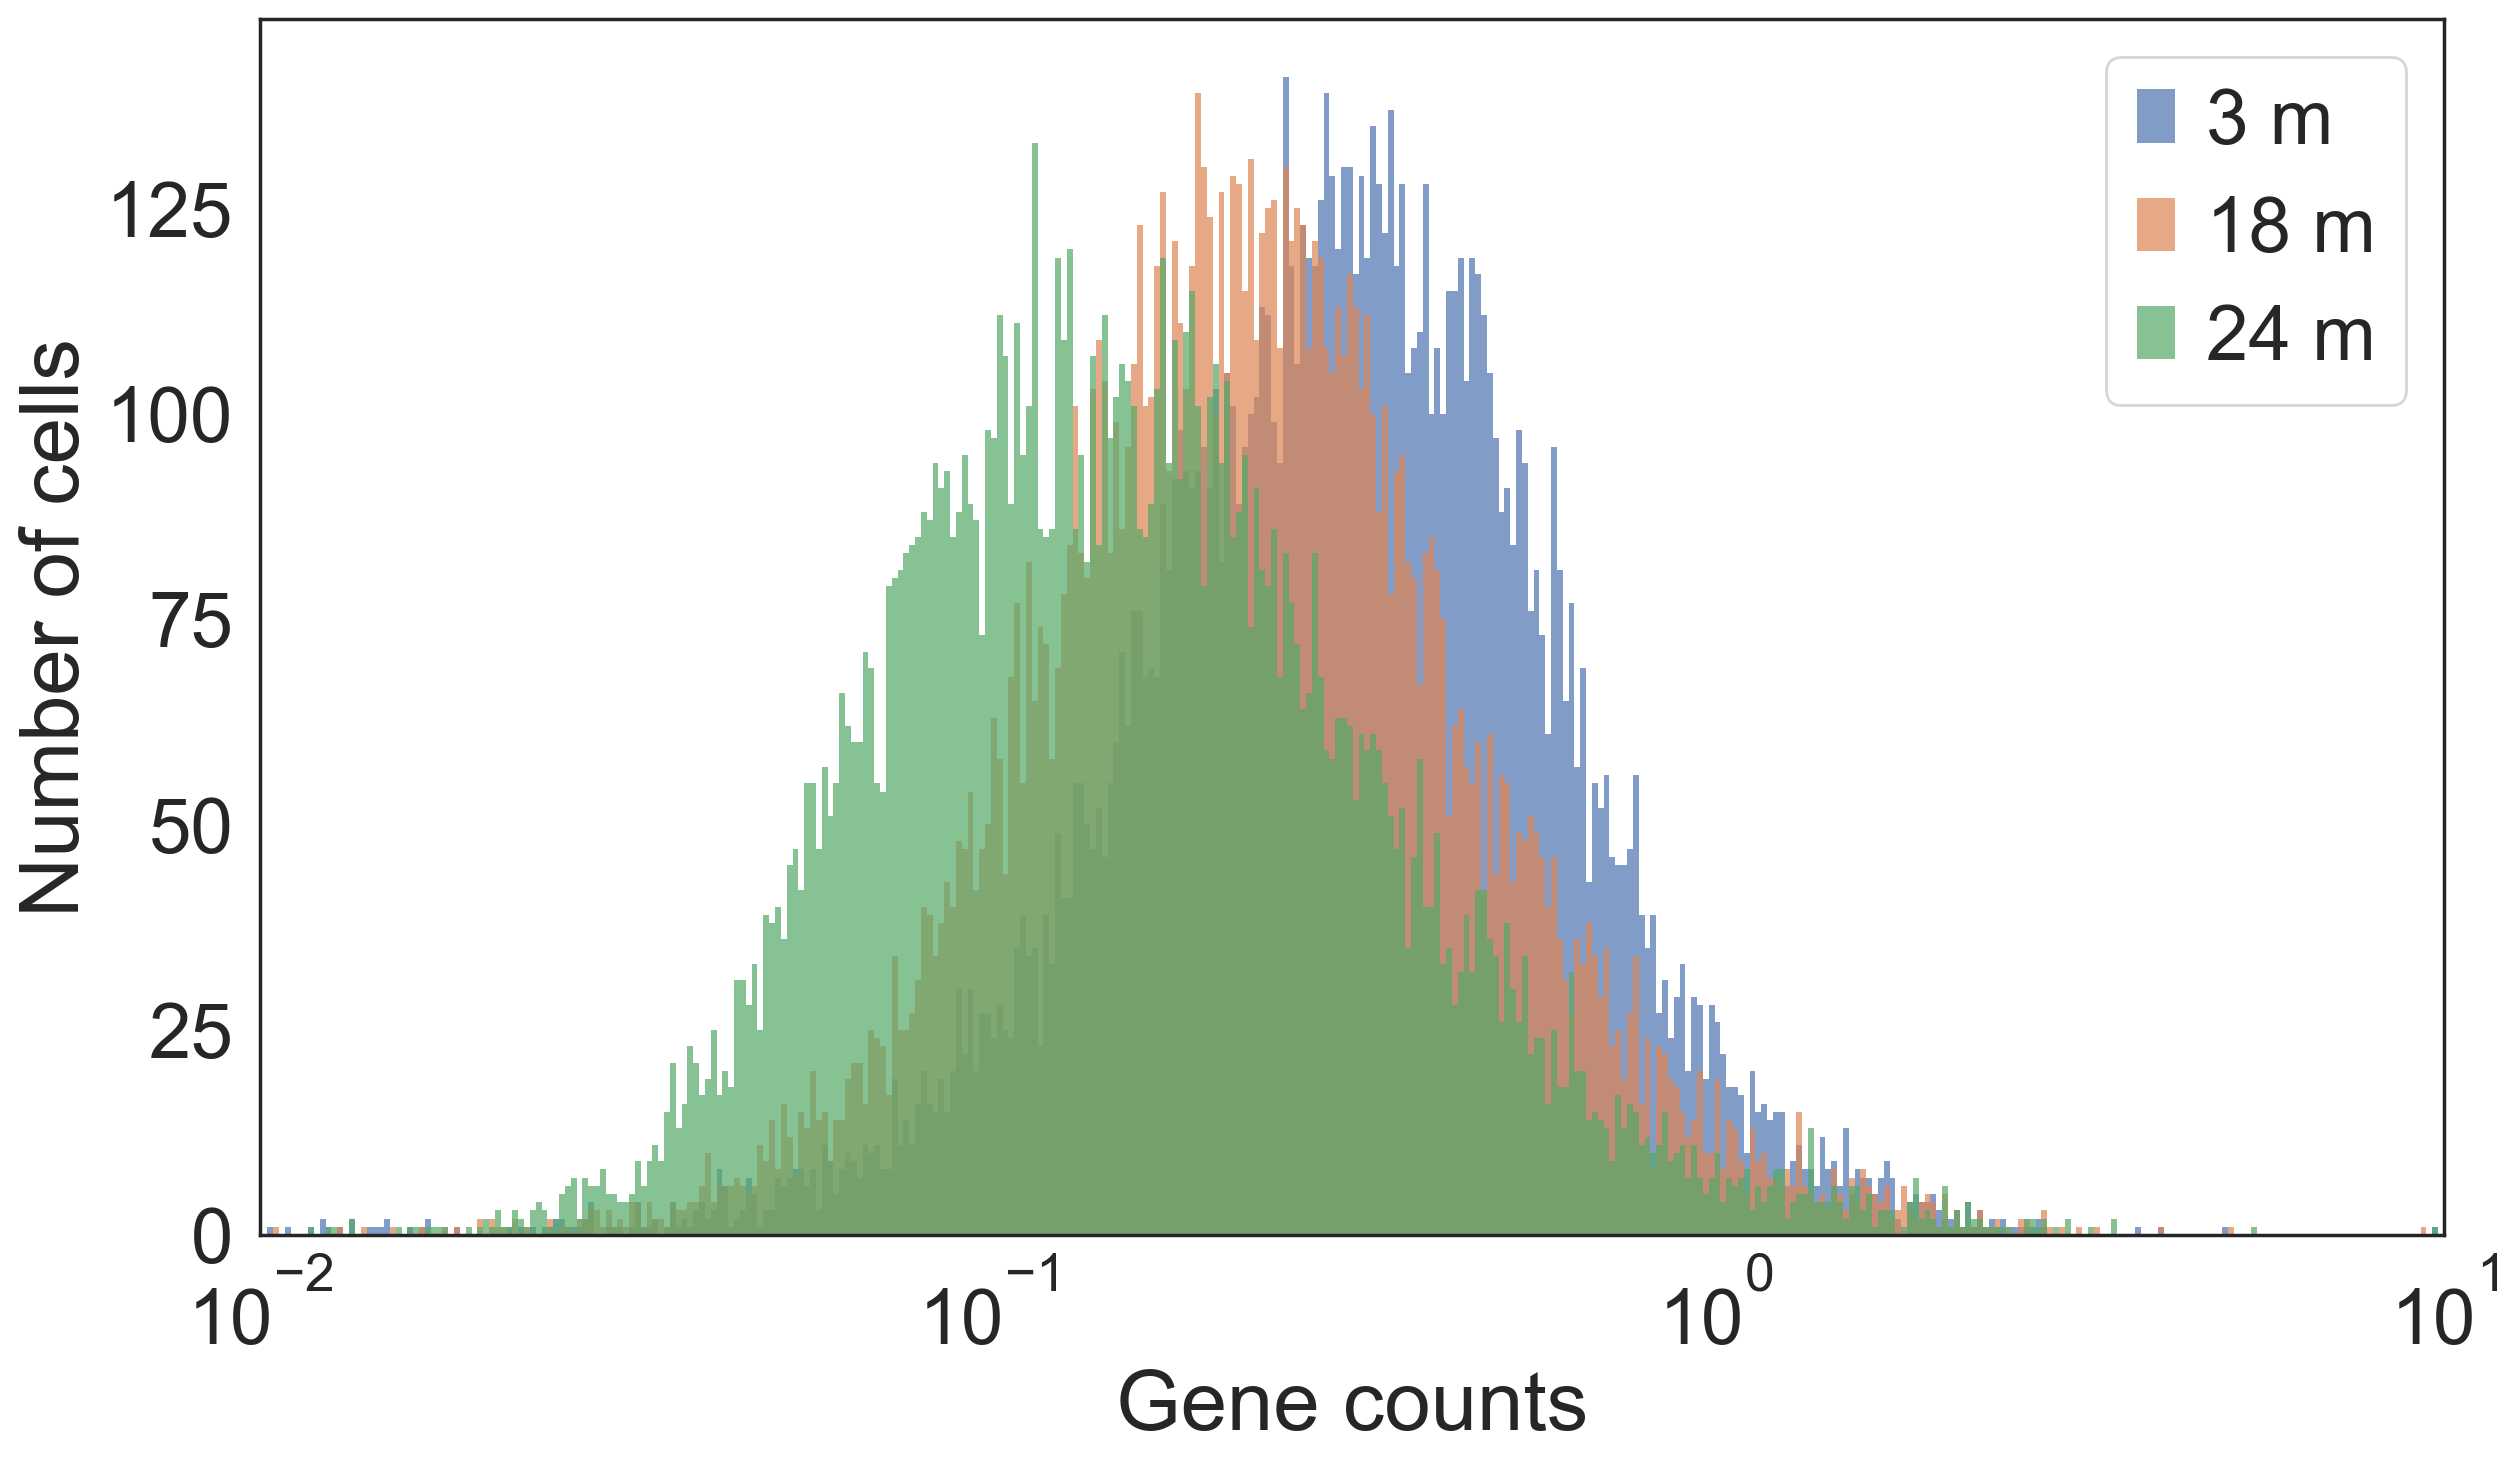

In [27]:
sns.set(font_scale = 2.5)
sns.set_style("white")
plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})
for age,df in zip([3,18,24],[age3m_mean,age18m_mean,age24m_mean]):
    sns.distplot(df, label=str(age)+' m',
                 bins=np.logspace(np.log10(0.001),np.log10(10.0), 500),
                 #bins=600,
                 hist_kws={'alpha':0.7}, 
                 kde=False)
plt.legend()
plt.xscale('log')
plt.xlabel('Gene counts')
plt.ylabel('Number of cells')
plt.xlim(0.01,10)
plt.show()

The below (commented) figure shows that both TF and TG counts separately. Both have a decreasing trend. These figures are not in the manuscript.

In [28]:
# tf_in_genes=(np.unique(list(set(list(age3m_df.columns))& set(list(unique_dict.keys())))))
# tg_in_genes=(np.unique(list(set(list(age3m_df.columns))& set(list(unique_dict.values())))))

# # Gene counts of TFs

# sns.set(font_scale = 2.5)
# sns.set_style("white")
# plt.rcParams['patch.edgecolor'] = 'none'
# plt.figure(figsize=(14, 8))
# plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})
# for age,df in zip([3,18,24],[age3m_mean[tf_in_genes],age18m_mean[tf_in_genes],age24m_mean[tf_in_genes]]):
#     sns.distplot(df, label=str(age)+' m',
#                  bins=np.logspace(np.log10(0.001),np.log10(10.0), 500),
#                  #bins=600,
#                  hist_kws={'alpha':0.7}, 
#                  kde=False)
# plt.legend()
# plt.title('TFs distribution mean gene counts per animal')
# plt.xscale('log')
# plt.xlabel('Gene counts')
# plt.ylabel('Number of cells')
# plt.xlim(0.01,10)
# plt.show()

# # Gene counts of TGs

# sns.set(font_scale = 2.5)
# sns.set_style("white")
# plt.rcParams['patch.edgecolor'] = 'none'
# plt.figure(figsize=(14, 8))
# plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})
# for age,df in zip([3,18,24],[age3m_mean[tg_in_genes],age18m_mean[tg_in_genes],age24m_mean[tg_in_genes]]):
#     sns.distplot(df, label=str(age)+' m',
#                  bins=np.logspace(np.log10(0.001),np.log10(10.0), 500),
#                  #bins=600,
#                  hist_kws={'alpha':0.7}, 
#                  kde=False)
# plt.legend()
# plt.title('TGs distribution mean gene counts per animal')
# plt.xscale('log')
# plt.xlabel('Gene counts')
# plt.ylabel('Number of cells')
# plt.xlim(0.01,10)
# plt.show()

# Figure 1 B

Shannon entropy of mean gene counts per animal across lifespan

In [32]:
# total cells

len(age3m_df)+len(age18m_df)+len(age24m_df)

3855

In [33]:
age3m_mean_animal

0610007C21Rik  0610007L01Rik  0610007N19Rik  0610007P08Rik  \
animal_id                                                               
3_10_M          0.656059       0.597111       0.330949       0.220857   
3_11_M          0.638704       0.492194       0.442516       0.113218   
3_38_F          0.560297       0.367929       0.244728       0.108394   
3_39_F          0.572111       0.417346       0.179087       0.123684   
3_8_M           0.541668       1.002012       0.248142       0.482507   
3_9_M           0.472328       0.692019       0.334828       0.242288   

           0610007P14Rik  0610007P22Rik  0610009B22Rik  0610009D07Rik  \
animal_id                                                               
3_10_M          0.312136       0.183908       0.166192       0.629353   
3_11_M          0.164927       0.161550       0.266114       0.502351   
3_38_F          0.234330       0.134121       0.155740       0.671374   
3_39_F          0.216286       0.176632       0.080428       0.727866   
3_8_M           0.270241       0.189503       0.146052       0.653840   
3_9_M           0.574010       0.286710       0.138622       0.617331   

           0610009L18Rik  0610009O20Rik  ...    Zswim6    Zswim7     Zufsp  \
animal_id                                ...                                 
3_10_M          0.051472       0.207039  ...  0.460172  0.178902  0.304717   
3_11_M          0.001300       0.432754  ...  0.714433  0.203262  0.366684   
3_38_F          0.188199       0.164401  ...  0.148495  0.246422  0.180110   
3_39_F          0.108687       0.182991  ...  0.352789  0.243852  0.160564   
3_8_M           0.098616       0.558448  ...  0.737104  0.160658  0.335372   
3_9_M           0.011781       0.240348  ...  0.450683  0.399865  0.372118   

               Zw10     Zwint      Zxdc    Zyg11b       Zyx     Zzef1  \
animal_id                                                               
3_10_M     0.495759  0.337406  0.465180  0.222083  0.737133  0.404277   
3_11_M     0.332034  0.221566  0.134595  0.044183  0.941912  0.321250   
3_38_F     0.186191  0.684602  0.176497  0.202790  0.557434  0.225120   
3_39_F     0.064835  0.669581  0.191327  0.207265  0.597090  0.132296   
3_8_M      0.293904  0.392448  0.391376  0.680811  0.862488  0.427488   
3_9_M      0.355788  0.391013  0.266721  0.389919  0.764340  0.412121   

               Zzz3  
animal_id            
3_10_M     0.440618  
3_11_M     0.340637  
3_38_F     0.204811  
3_39_F     0.196600  
3_8_M      0.585852  
3_9_M      0.866831  

[6 rows x 10835 columns]

In [34]:
type(age3m_mean_animal)

new_animals_df = pd.concat([age3m_mean_animal,age18m_mean_animal,age24m_mean_animal])

In [35]:
# extracting age and sex of animal to make a column

list(new_animals_df.index.values)
age=[]
sex=[]
for i in list(new_animals_df.index.values):
    age.append(i.split('_')[0]+'m')
    sex.append(i.split('_')[2])
    

Calculating Shannon entropy of genes after logarithmic binning of gene count values

In [37]:
#ORIGINAL bin width - total 500 bins

ent_mean_animal=[]

for index, animal in new_animals_df.iterrows():
    age_cut=pd.cut(animal, bins=2**np.linspace(0, 15, 500)).sort_index()
    counts=age_cut.value_counts()
    cnt=counts/len(counts)
    ent_mean_animal.append(entropy(cnt))

In [38]:
ent_mean_animal

[3.5108342064401312,
 3.7817087121568735,
 3.6795951432430174,
 3.615376788939851,
 3.4548086310931927,
 3.5565813338024252,
 3.637465509598794,
 3.7756482624554675,
 3.630016067366788,
 3.620614623238307,
 3.8612779478550303,
 3.774622901443257,
 3.7615423379767075,
 3.7306147166275903]

In [39]:
new_animals_df.head()

0610007C21Rik  0610007L01Rik  0610007N19Rik  0610007P08Rik  \
animal_id                                                               
3_10_M          0.656059       0.597111       0.330949       0.220857   
3_11_M          0.638704       0.492194       0.442516       0.113218   
3_38_F          0.560297       0.367929       0.244728       0.108394   
3_39_F          0.572111       0.417346       0.179087       0.123684   
3_8_M           0.541668       1.002012       0.248142       0.482507   

           0610007P14Rik  0610007P22Rik  0610009B22Rik  0610009D07Rik  \
animal_id                                                               
3_10_M          0.312136       0.183908       0.166192       0.629353   
3_11_M          0.164927       0.161550       0.266114       0.502351   
3_38_F          0.234330       0.134121       0.155740       0.671374   
3_39_F          0.216286       0.176632       0.080428       0.727866   
3_8_M           0.270241       0.189503       0.146052       0.653840   

           0610009L18Rik  0610009O20Rik  ...    Zswim6    Zswim7     Zufsp  \
animal_id                                ...                                 
3_10_M          0.051472       0.207039  ...  0.460172  0.178902  0.304717   
3_11_M          0.001300       0.432754  ...  0.714433  0.203262  0.366684   
3_38_F          0.188199       0.164401  ...  0.148495  0.246422  0.180110   
3_39_F          0.108687       0.182991  ...  0.352789  0.243852  0.160564   
3_8_M           0.098616       0.558448  ...  0.737104  0.160658  0.335372   

               Zw10     Zwint      Zxdc    Zyg11b       Zyx     Zzef1  \
animal_id                                                               
3_10_M     0.495759  0.337406  0.465180  0.222083  0.737133  0.404277   
3_11_M     0.332034  0.221566  0.134595  0.044183  0.941912  0.321250   
3_38_F     0.186191  0.684602  0.176497  0.202790  0.557434  0.225120   
3_39_F     0.064835  0.669581  0.191327  0.207265  0.597090  0.132296   
3_8_M      0.293904  0.392448  0.391376  0.680811  0.862488  0.427488   

               Zzz3  
animal_id            
3_10_M     0.440618  
3_11_M     0.340637  
3_38_F     0.204811  
3_39_F     0.196600  
3_8_M      0.585852  

[5 rows x 10835 columns]

In [40]:
#ORIGINAL
new_animals_df['age']= age
new_animals_df['sex']= sex
new_animals_df['entropy']=ent_mean_animal

<AxesSubplot:xlabel='age', ylabel='entropy'>

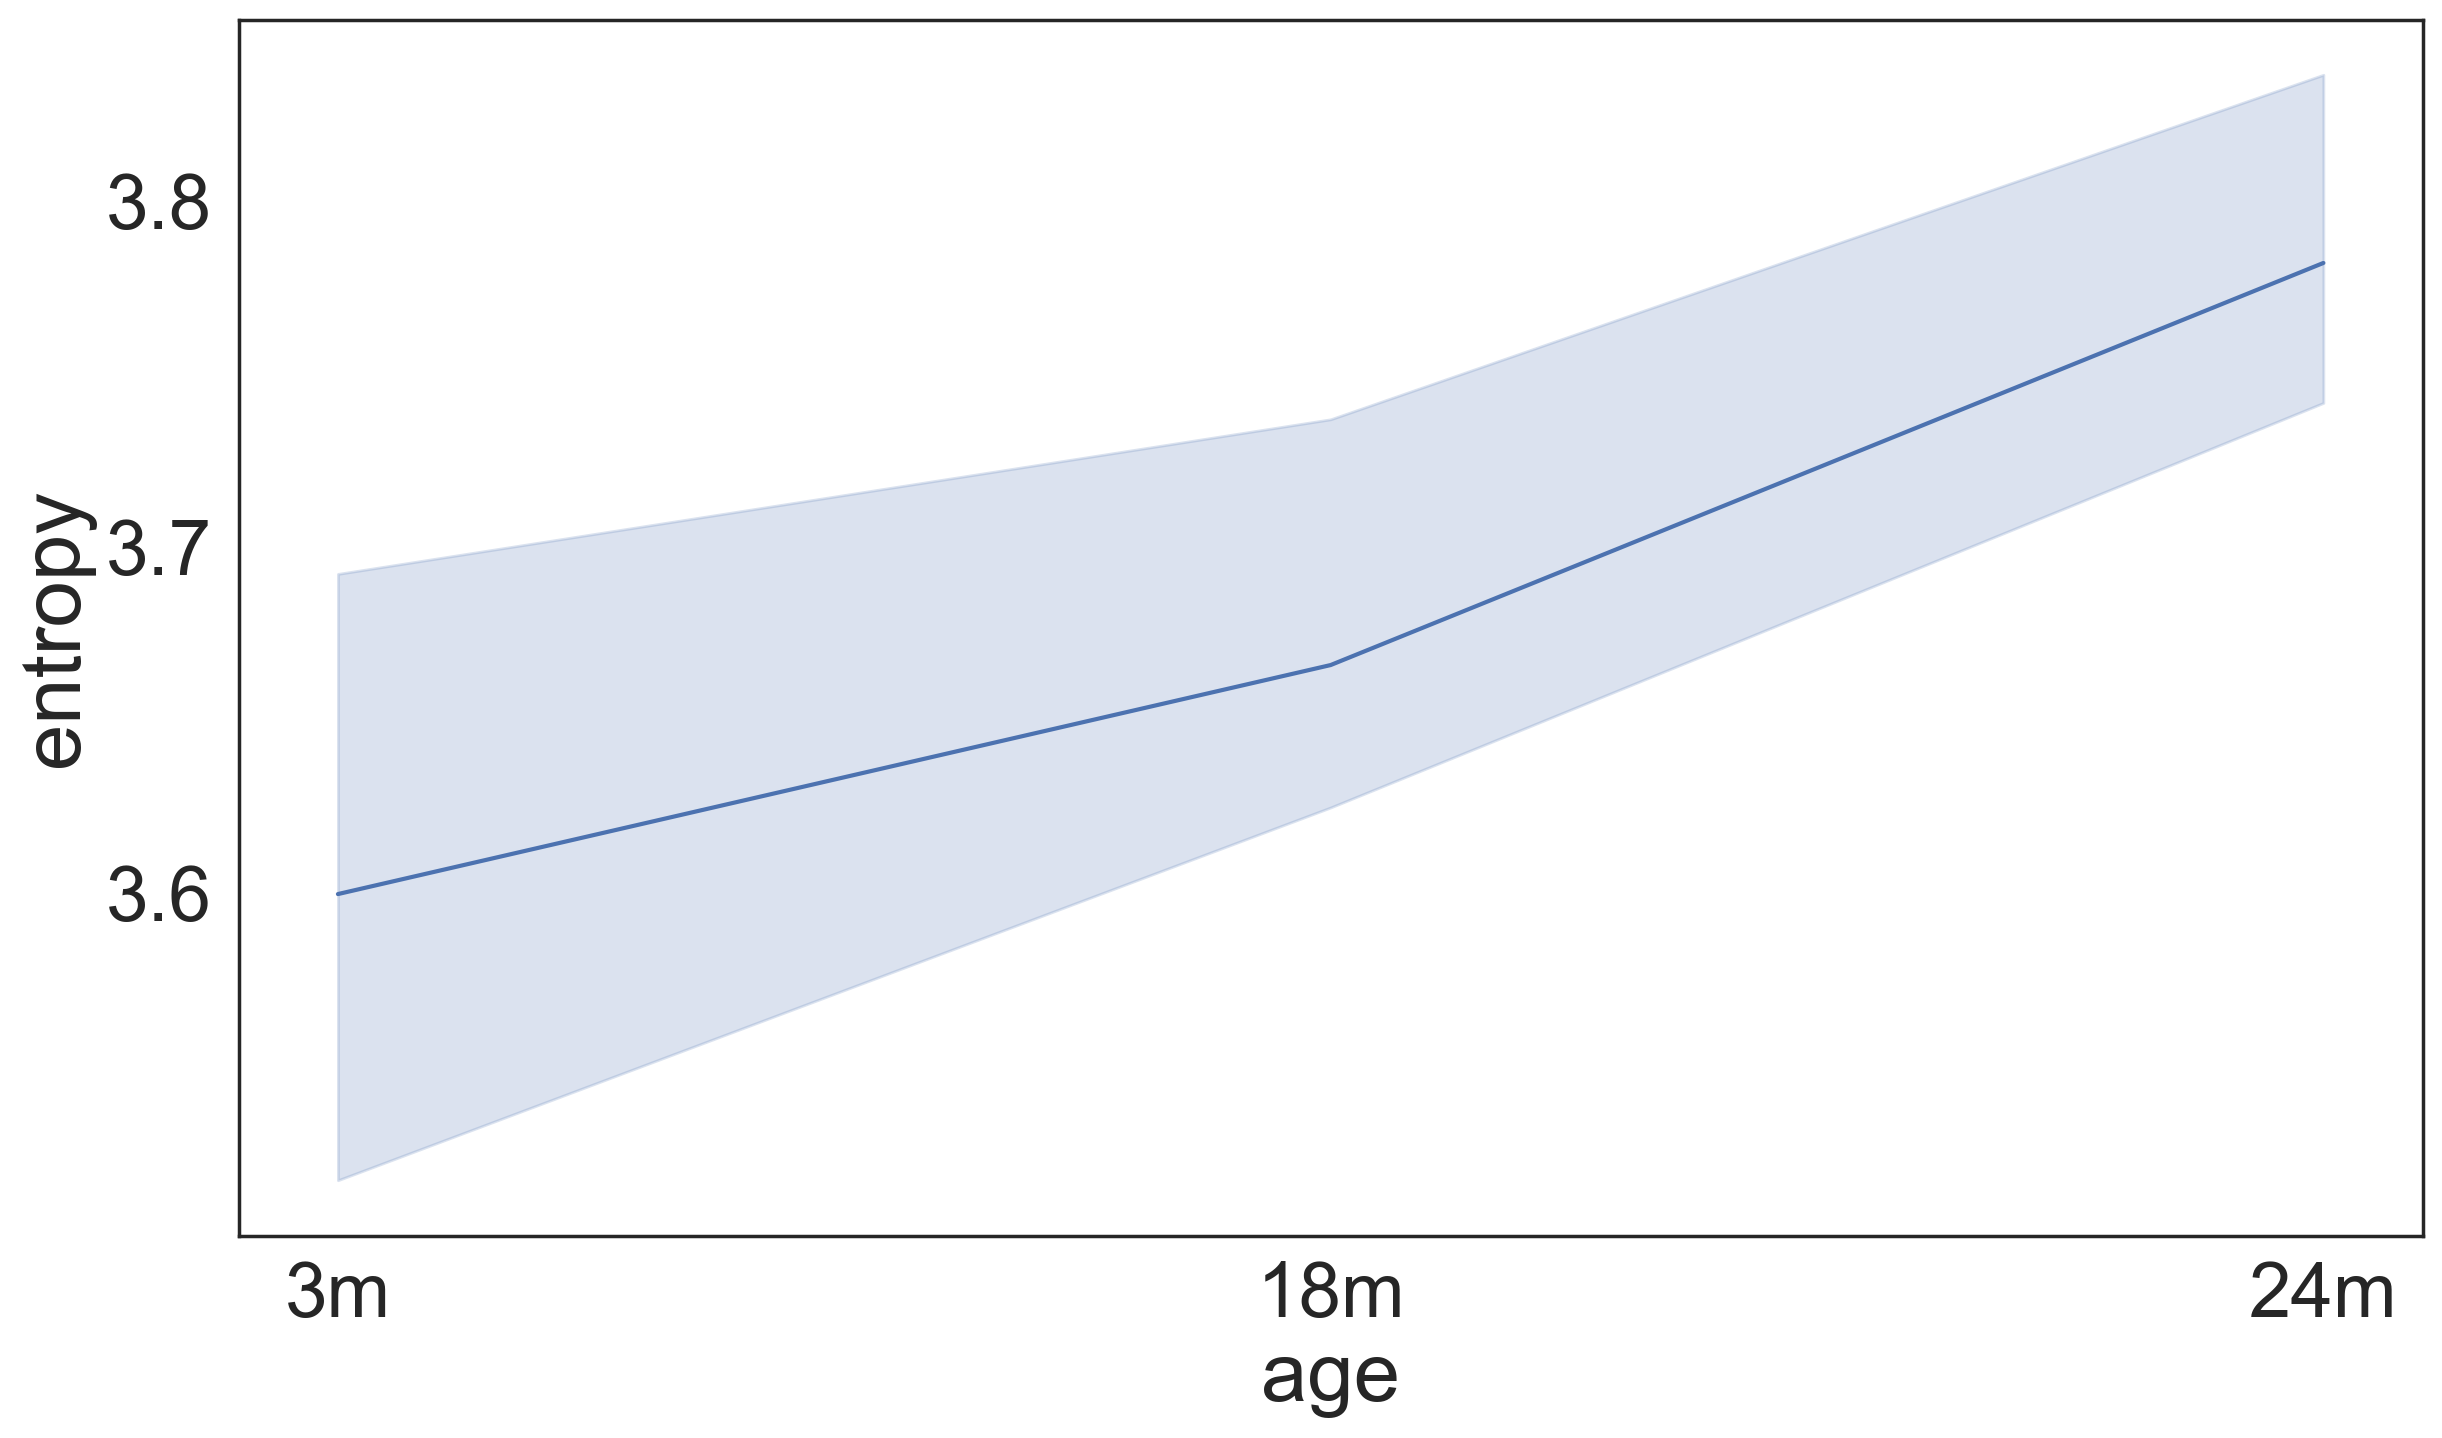

In [41]:
#ORIGINAL (linspace 500 bins)

sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

sns.lineplot(data=new_animals_df, x='age',y='entropy')


This is the Shannon entropy of genes counts per cell, across the lifespan of mice. This is figure 1 B. This shows that the gene expression values has increased disorderliness with age. I tried this with different bin width, and the trend remainined the same.

In [42]:
##### tried different bin width:

# # modified (linspace 100 bins)

# ent_mean_animal=[]

# for index, animal in new_animals_df.iterrows():    
#     age_cut=pd.cut(animal, bins=2**np.linspace(0, 15, 100)).sort_index()
#     counts=age_cut.value_counts()
#     cnt=counts/len(counts)
#     ent_mean_animal.append(entropy(cnt))

# print(ent_mean_animal.head())

# new_animals_df['age']= age
# new_animals_df['sex']= sex
# new_animals_df['entropy_100bins']=ent_mean_animal

# # modified (linspace 100 bins)

# sns.set(font_scale = 2.5)
# sns.set_style("white")
# #plt.rcParams['patch.edgecolor'] = 'none'
# plt.figure(figsize=(14, 8))
# plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

# sns.pointplot(data=new_animals_df, x='age',y='entropy_100bins')

# Figure 1D and 1E

# Calculating MI, entropy and conditional entropy for each cell.

For each cell, we select genes that are a part of the transcriptional regulatory network (TRN). 

The TRN has expression values for input transcription factor and output target gene. 

We compute the mutual information of all the TFs with all the TGs per cell. 

We plot the average mutual information of TFs and TGs per cell accross the lifespan of mice.  

In [43]:
allcells_df=pd.concat([age3m_df,age18m_df,age24m_df])

In [44]:
allcells_df.head()

0610007C21Rik  0610007L01Rik  0610007N19Rik  \
A1.B002765.3_38_F.1.1-1-1        1.761105       1.541098            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       1.788955            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       3.050025            0.0   
A10.B002769.3_39_F.1.1-1-1       1.564775       0.000000            0.0   

                            0610007P08Rik  0610007P14Rik  0610007P22Rik  \
A1.B002765.3_38_F.1.1-1-1             0.0            0.0            0.0   
A1.D042103.3_11_M.1-1-1               0.0            0.0            0.0   
A1.D042186.3_8_M.1.1-1-1              0.0            0.0            0.0   
A10.B002765.3_38_F.1.1-1-1            0.0            0.0            0.0   
A10.B002769.3_39_F.1.1-1-1            0.0            0.0            0.0   

                            0610009B22Rik  0610009D07Rik  0610009L18Rik  \
A1.B002765.3_38_F.1.1-1-1        0.000000       0.000000            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       0.384158            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       1.533476            0.0   
A10.B002769.3_39_F.1.1-1-1       2.696855       0.817633            0.0   

                            0610009O20Rik  ...     Zwint  Zxdc    Zyg11b  \
A1.B002765.3_38_F.1.1-1-1        0.000000  ...  1.522642   0.0  0.000000   
A1.D042103.3_11_M.1-1-1          0.000000  ...  0.000000   0.0  0.000000   
A1.D042186.3_8_M.1.1-1-1         0.000000  ...  0.000000   0.0  0.161871   
A10.B002765.3_38_F.1.1-1-1       0.000000  ...  0.025267   0.0  0.000000   
A10.B002769.3_39_F.1.1-1-1       1.073734  ...  0.000000   0.0  0.029860   

                                 Zyx     Zzef1      Zzz3  age  \
A1.B002765.3_38_F.1.1-1-1   1.806709  0.000000  0.000000   3m   
A1.D042103.3_11_M.1-1-1     0.000000  0.000000  0.000000   3m   
A1.D042186.3_8_M.1.1-1-1    1.352870  1.701163  0.289918   3m   
A10.B002765.3_38_F.1.1-1-1  0.000000  0.000000  0.000000   3m   
A10.B002769.3_39_F.1.1-1-1  0.719527  0.024443  0.000000   3m   

                                                  celltype  animal_id     sex  
A1.B002765.3_38_F.1.1-1-1   skeletal muscle satellite cell     3_38_F  female  
A1.D042103.3_11_M.1-1-1     skeletal muscle satellite cell     3_11_M    male  
A1.D042186.3_8_M.1.1-1-1    skeletal muscle satellite cell      3_8_M    male  
A10.B002765.3_38_F.1.1-1-1  skeletal muscle satellite cell     3_38_F  female  
A10.B002769.3_39_F.1.1-1-1  skeletal muscle satellite cell     3_39_F  female  

[5 rows x 10839 columns]

# Shannon entropy of genes that are not in TRN

Before selecting genes that are a part of the TRN, we compute the Shannon entropy of genes that are not a part of teh regulatory network and observe a different trend. This is in supplemental figure.

In [45]:
lst=list(age3m_df.columns)
lst = lst[:len(lst)-4]
tftg_notin_genes=(np.unique(list(set(lst)- set(list(unique_dict.keys()))- set(list(unique_dict.values())))))

In [46]:
# entropy of all genes per cell
ent_cell_all=[]
df=allcells_df.iloc[: , :-4]

for cellid, row in df.iterrows():
    cell_all=pd.cut(row[tftg_notin_genes], bins=2**np.linspace(0, 15, 500)).sort_index()
    counts=cell_all.value_counts()
    cnt=counts/len(counts)
    ent_cell_all.append(entropy(cnt))    

In [47]:
df.head()

0610007C21Rik  0610007L01Rik  0610007N19Rik  \
A1.B002765.3_38_F.1.1-1-1        1.761105       1.541098            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       1.788955            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       3.050025            0.0   
A10.B002769.3_39_F.1.1-1-1       1.564775       0.000000            0.0   

                            0610007P08Rik  0610007P14Rik  0610007P22Rik  \
A1.B002765.3_38_F.1.1-1-1             0.0            0.0            0.0   
A1.D042103.3_11_M.1-1-1               0.0            0.0            0.0   
A1.D042186.3_8_M.1.1-1-1              0.0            0.0            0.0   
A10.B002765.3_38_F.1.1-1-1            0.0            0.0            0.0   
A10.B002769.3_39_F.1.1-1-1            0.0            0.0            0.0   

                            0610009B22Rik  0610009D07Rik  0610009L18Rik  \
A1.B002765.3_38_F.1.1-1-1        0.000000       0.000000            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       0.384158            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       1.533476            0.0   
A10.B002769.3_39_F.1.1-1-1       2.696855       0.817633            0.0   

                            0610009O20Rik  ...    Zswim6    Zswim7  Zufsp  \
A1.B002765.3_38_F.1.1-1-1        0.000000  ...  0.000000  0.000000    0.0   
A1.D042103.3_11_M.1-1-1          0.000000  ...  6.832855  0.000000    0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000  ...  3.882913  0.000000    0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000  ...  0.000000  0.000000    0.0   
A10.B002769.3_39_F.1.1-1-1       1.073734  ...  0.000000  1.812647    0.0   

                            Zw10     Zwint  Zxdc    Zyg11b       Zyx  \
A1.B002765.3_38_F.1.1-1-1    0.0  1.522642   0.0  0.000000  1.806709   
A1.D042103.3_11_M.1-1-1      0.0  0.000000   0.0  0.000000  0.000000   
A1.D042186.3_8_M.1.1-1-1     0.0  0.000000   0.0  0.161871  1.352870   
A10.B002765.3_38_F.1.1-1-1   0.0  0.025267   0.0  0.000000  0.000000   
A10.B002769.3_39_F.1.1-1-1   0.0  0.000000   0.0  0.029860  0.719527   

                               Zzef1      Zzz3  
A1.B002765.3_38_F.1.1-1-1   0.000000  0.000000  
A1.D042103.3_11_M.1-1-1     0.000000  0.000000  
A1.D042186.3_8_M.1.1-1-1    1.701163  0.289918  
A10.B002765.3_38_F.1.1-1-1  0.000000  0.000000  
A10.B002769.3_39_F.1.1-1-1  0.024443  0.000000  

[5 rows x 10835 columns]

Text(0.5, 1.0, 'genes not in transcriptional regulatory network')

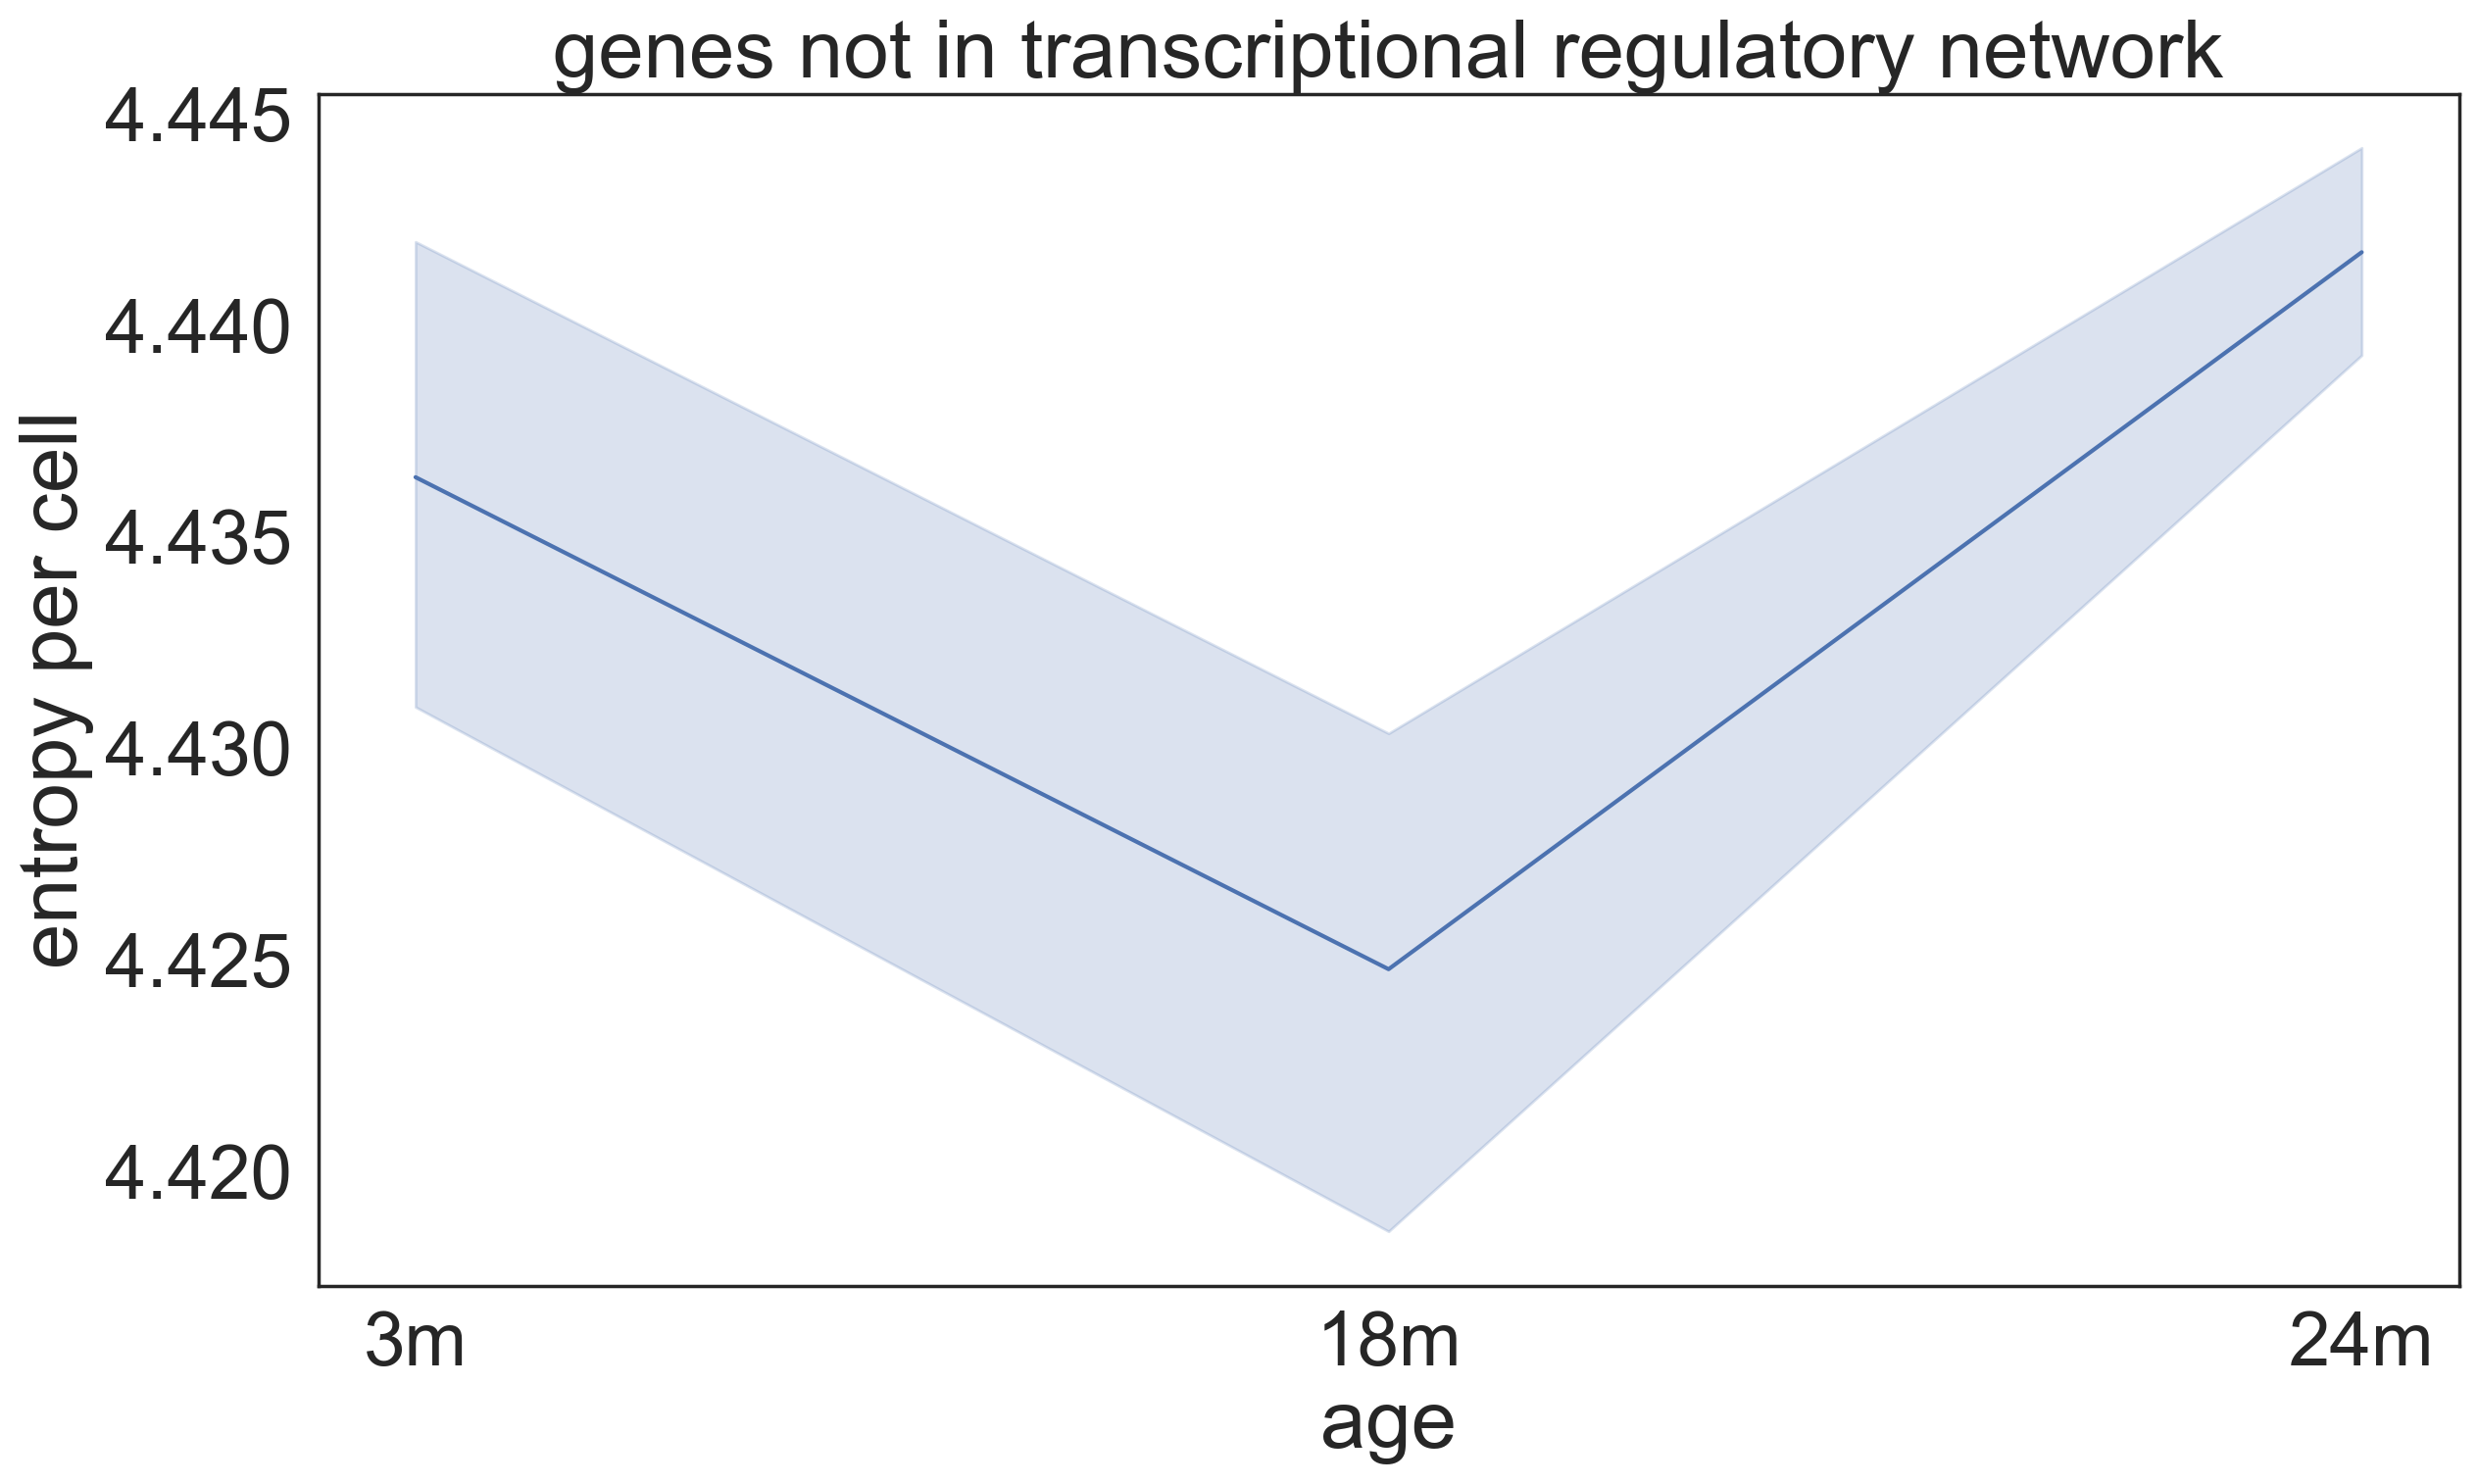

In [48]:
df['nottftg_genes_entropy'] = ent_cell_all
df['age']=allcells_df['age']

sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

sns.lineplot(data=df, x= 'age', y= 'nottftg_genes_entropy')
plt.ylabel('entropy per cell')
plt.title('genes not in transcriptional regulatory network')

It is interesting that genes that are not a part of the  regulatory network don't have a steady increasing trend. This suggests that there may be some preferential regulation of certain genes. This is supp fig 2B.

Focusing on the genes that are a part of the TRN, we will apply Shannon's Noisy channel theorem to the individual TF-TG pairs (transcription factor-target gene). We will find total entropy of each gene, mutual information between TF-TG and conditional entropy of TF|TG amd TG|TF.

In [49]:
# Dictionary of TF-TG pairs in our dataset

tf_i=[]
tg_j=[]
count=0

for i,j in unique_dict.items():
    #print(i)
    try:
        if (i in list(new_animals_df.columns)) and (j in list(new_animals_df.columns)):
            tf_i.append(i)
            tg_j.append(j)
    except:
        count+=1

present_tf_tg_dict=dict(zip(tf_i,tg_j))

In [50]:
len(present_tf_tg_dict)

355

In [51]:
present_tf_tg_dict

{'Aatf': 'Trp53',
 'Aebp2': 'Snai2',
 'Ahr': 'Vav3',
 'Apbb1': 'Notch1',
 'Apc': 'Trp53',
 'Apex1': 'Tlr4',
 'Arid5b': 'Sox9',
 'Arl6ip5': 'Xrcc1',
 'Ash1l': 'Timp1',
 'Asxl1': 'Fabp4',
 'Atf1': 'Thbs1',
 'Atf3': 'Tnfrsf10b',
 'Atf4': 'Trib3',
 'Atf6': 'Wbp1',
 'Atm': 'Trp53',
 'Bach1': 'Trp53',
 'Batf3': 'Irf8',
 'Bcl11b': 'Zbtb7b',
 'Bcl3': 'Ubc',
 'Bcl6b': 'Rbpj',
 'Bhlhe40': 'Il2ra',
 'Bmi1': 'Pten',
 'Bmp4': 'Chst11',
 'Brca2': 'Cdkn1a',
 'Btg2': 'Creb1',
 'Bub3': 'Apod',
 'Cd7': 'Nfkb1',
 'Cebpa': 'Zbtb16',
 'Cebpg': 'Il6',
 'Cebpz': 'Hspa1b',
 'Chd7': 'Sox4',
 'Chd8': 'Tcf4',
 'Cited2': 'Wnt4',
 'Clock': 'Vwf',
 'Cnot3': 'Zfx',
 'Cnot7': 'Tob1',
 'Creb1': 'Twist1',
 'Creb3': 'Herpud1',
 'Crebbp': 'Trp53',
 'Crtc1': 'Creb1',
 'Cry1': 'Per2',
 'Csf1': 'Cd36',
 'Ctf1': 'Tgfb1',
 'Ctnnb1': 'Wnt4',
 'Ctr9': 'Il6',
 'Dab2': 'Axin1',
 'Daxx': 'Trp53',
 'Dbp': 'Per1',
 'Ddit3': 'Nos3',
 'Ddx5': 'Igf2',
 'Ddx54': 'Mbp',
 'Deaf1': 'Eif4g3',
 'Dmap1': 'Bmi1',
 'Dmrt2': 'Myf5',
 'Dnajc2': '

In [55]:
# df_sub=allcells_df.iloc[: , :-4]
# df_sub.head()
df.head()

0610007C21Rik  0610007L01Rik  0610007N19Rik  \
A1.B002765.3_38_F.1.1-1-1        1.761105       1.541098            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       1.788955            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       3.050025            0.0   
A10.B002769.3_39_F.1.1-1-1       1.564775       0.000000            0.0   

                            0610007P08Rik  0610007P14Rik  0610007P22Rik  \
A1.B002765.3_38_F.1.1-1-1             0.0            0.0            0.0   
A1.D042103.3_11_M.1-1-1               0.0            0.0            0.0   
A1.D042186.3_8_M.1.1-1-1              0.0            0.0            0.0   
A10.B002765.3_38_F.1.1-1-1            0.0            0.0            0.0   
A10.B002769.3_39_F.1.1-1-1            0.0            0.0            0.0   

                            0610009B22Rik  0610009D07Rik  0610009L18Rik  \
A1.B002765.3_38_F.1.1-1-1        0.000000       0.000000            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       0.384158            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       1.533476            0.0   
A10.B002769.3_39_F.1.1-1-1       2.696855       0.817633            0.0   

                            0610009O20Rik  ...    Zswim6    Zswim7  Zufsp  \
A1.B002765.3_38_F.1.1-1-1        0.000000  ...  0.000000  0.000000    0.0   
A1.D042103.3_11_M.1-1-1          0.000000  ...  6.832855  0.000000    0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000  ...  3.882913  0.000000    0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000  ...  0.000000  0.000000    0.0   
A10.B002769.3_39_F.1.1-1-1       1.073734  ...  0.000000  1.812647    0.0   

                            Zw10     Zwint  Zxdc    Zyg11b       Zyx  \
A1.B002765.3_38_F.1.1-1-1    0.0  1.522642   0.0  0.000000  1.806709   
A1.D042103.3_11_M.1-1-1      0.0  0.000000   0.0  0.000000  0.000000   
A1.D042186.3_8_M.1.1-1-1     0.0  0.000000   0.0  0.161871  1.352870   
A10.B002765.3_38_F.1.1-1-1   0.0  0.025267   0.0  0.000000  0.000000   
A10.B002769.3_39_F.1.1-1-1   0.0  0.000000   0.0  0.029860  0.719527   

                               Zzef1      Zzz3  
A1.B002765.3_38_F.1.1-1-1   0.000000  0.000000  
A1.D042103.3_11_M.1-1-1     0.000000  0.000000  
A1.D042186.3_8_M.1.1-1-1    1.701163  0.289918  
A10.B002765.3_38_F.1.1-1-1  0.000000  0.000000  
A10.B002769.3_39_F.1.1-1-1  0.024443  0.000000  

[5 rows x 10835 columns]

In [53]:
# taking the categorical columns out from count matrix ordered by age

df=df.iloc[: , :-2]

In [56]:
def cell_entropy(df,present_tf_tg_dict):
    '''
    df: dataframe with genes as columns, cells as rows, with 'animal_id' as a column
    present_tf_tg_dict: dictionary of tf and tg - present pairs in the data
    ''' 
    
    ent_cell_tf=[]
    ent_cell_tg=[]
    
    for cellid, row in df.iterrows():
        
        cell_tf=pd.cut(row[present_tf_tg_dict.keys()], bins=2**np.linspace(0, 15, 500)).sort_index()
        counts=cell_tf.value_counts()
        cnt=counts/len(counts)
        ent_cell_tf.append(entropy(cnt))
        
        cell_tg=pd.cut(row[present_tf_tg_dict.values()], bins=2**np.linspace(0, 15, 500)).sort_index()
        counts=cell_tg.value_counts()
        cnt=counts/len(counts)
        ent_cell_tg.append(entropy(cnt))

            
    return ent_cell_tf,ent_cell_tg

In [57]:
#ent_cell_tf,ent_cell_tg = cell_entropy(allcells_df,present_tf_tg_dict)

In [58]:
#ent_cell_tf

In [59]:
# ordered age
ent_cell_tf,ent_cell_tg = cell_entropy(df,present_tf_tg_dict)

C:\Users\SRS204\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [60]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

def calc_normMI(x, y):
    mi = normalized_mutual_info_score(x,y)
    return mi

def calc_adjMI(x, y):
    mi = adjusted_mutual_info_score(x,y)
    return mi


In [61]:
# calculating mutual information using normalized mi_score

def cell_norm_mi(df,present_tf_tg_dict):
    '''
    df: dataframe with genes as columns, animals as rows
    unique_dict: tf-tg pairs as a dict
    ''' 
    mi_cell=[]
    count=0
    
    #df=df.iloc[: , :-4]
    
    for cellid, row in df.iterrows():
        
        try:
            mi_cell.append(calc_normMI(list(row[list(present_tf_tg_dict.keys())]),list(row[list(present_tf_tg_dict.values())])))

        except:
            count+=1
            pass
    
    
    return mi_cell

In [62]:
# calculating mutual information using adjusted mi_score

def cell_adj_mi(df,present_tf_tg_dict):
    '''
    df: dataframe with genes as columns, animals as rows
    unique_dict: tf-tg pairs as a dict
    ''' 
    mi_cell=[]
    count=0
    
    #df=df.iloc[: , :-4]
    
    for cellid, row in df.iterrows():
        
        try:
            mi_cell.append(calc_adjMI(list(row[list(present_tf_tg_dict.keys())]),list(row[list(present_tf_tg_dict.values())])))

        except:
            count+=1
            pass
    
    
    return mi_cell

In [63]:
#mi_cell=cell_mi(allcells_df,present_tf_tg_dict)

In [64]:
#ordered age
norm_mi_cell=cell_norm_mi(df,present_tf_tg_dict)

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

In [65]:
adj_mi_cell=cell_adj_mi(df,present_tf_tg_dict)

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserW

In [66]:
df['age']=allcells_df['age']

df['entropy_cell_tf']=ent_cell_tf
df['entropy_cell_tg']=ent_cell_tg
df['norm_mi_cell']=norm_mi_cell
df['adj_mi_cell']=adj_mi_cell

df['norm_condi_tf|tg_cell']=df['entropy_cell_tf']-df['norm_mi_cell']
df['norm_condi_tg|tf_cell']=df['entropy_cell_tg']-df['norm_mi_cell']
df['adj_condi_tf|tg_cell']=df['entropy_cell_tf']-df['adj_mi_cell']
df['adj_condi_tg|tf_cell']=df['entropy_cell_tg']-df['adj_mi_cell']


In [67]:
df.head()
# avg_allcells_df=allcells_df.groupby('age').mean()

0610007C21Rik  0610007L01Rik  0610007N19Rik  \
A1.B002765.3_38_F.1.1-1-1        1.761105       1.541098            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       1.788955            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       3.050025            0.0   
A10.B002769.3_39_F.1.1-1-1       1.564775       0.000000            0.0   

                            0610007P08Rik  0610007P14Rik  0610007P22Rik  \
A1.B002765.3_38_F.1.1-1-1             0.0            0.0            0.0   
A1.D042103.3_11_M.1-1-1               0.0            0.0            0.0   
A1.D042186.3_8_M.1.1-1-1              0.0            0.0            0.0   
A10.B002765.3_38_F.1.1-1-1            0.0            0.0            0.0   
A10.B002769.3_39_F.1.1-1-1            0.0            0.0            0.0   

                            0610009B22Rik  0610009D07Rik  0610009L18Rik  \
A1.B002765.3_38_F.1.1-1-1        0.000000       0.000000            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       0.384158            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       1.533476            0.0   
A10.B002769.3_39_F.1.1-1-1       2.696855       0.817633            0.0   

                            0610009O20Rik  ...      Zzz3  age  \
A1.B002765.3_38_F.1.1-1-1        0.000000  ...  0.000000   3m   
A1.D042103.3_11_M.1-1-1          0.000000  ...  0.000000   3m   
A1.D042186.3_8_M.1.1-1-1         0.000000  ...  0.289918   3m   
A10.B002765.3_38_F.1.1-1-1       0.000000  ...  0.000000   3m   
A10.B002769.3_39_F.1.1-1-1       1.073734  ...  0.000000   3m   

                            entropy_cell_tf  entropy_cell_tg  norm_mi_cell  \
A1.B002765.3_38_F.1.1-1-1          3.461155         2.787838      0.237433   
A1.D042103.3_11_M.1-1-1            3.248189         2.821225      0.130448   
A1.D042186.3_8_M.1.1-1-1           3.832496         2.964179      0.341543   
A10.B002765.3_38_F.1.1-1-1         3.650747         2.395799      0.239135   
A10.B002769.3_39_F.1.1-1-1         3.560841         2.667208      0.384550   

                            adj_mi_cell  norm_condi_tf|tg_cell  \
A1.B002765.3_38_F.1.1-1-1      0.016711               3.223722   
A1.D042103.3_11_M.1-1-1       -0.033429               3.117741   
A1.D042186.3_8_M.1.1-1-1       0.020705               3.490953   
A10.B002765.3_38_F.1.1-1-1    -0.009651               3.411612   
A10.B002769.3_39_F.1.1-1-1     0.009764               3.176291   

                            norm_condi_tg|tf_cell  adj_condi_tf|tg_cell  \
A1.B002765.3_38_F.1.1-1-1                2.550405              3.444444   
A1.D042103.3_11_M.1-1-1                  2.690777              3.281619   
A1.D042186.3_8_M.1.1-1-1                 2.622636              3.811790   
A10.B002765.3_38_F.1.1-1-1               2.156664              3.660398   
A10.B002769.3_39_F.1.1-1-1               2.282658              3.551077   

                            adj_condi_tg|tf_cell  
A1.B002765.3_38_F.1.1-1-1               2.771127  
A1.D042103.3_11_M.1-1-1                 2.854654  
A1.D042186.3_8_M.1.1-1-1                2.943474  
A10.B002765.3_38_F.1.1-1-1              2.405450  
A10.B002769.3_39_F.1.1-1-1              2.657444  

[5 rows x 10844 columns]

In [68]:
# sorted age
avg_allcells_df=df.groupby('age').mean()

In [69]:
avg_allcells_df.index

Index(['18m', '24m', '3m'], dtype='object', name='age')

In [70]:
avg_allcells_df=avg_allcells_df.reindex(['3m','18m', '24m'])
final_df = avg_allcells_df
final_df

0610007C21Rik  0610007L01Rik  0610007N19Rik  0610007P08Rik  \
age                                                               
3m        0.562583       0.616423       0.261602       0.241204   
18m       0.668275       0.389955       0.210504       0.142548   
24m       0.564742       0.293902       0.224080       0.055116   

     0610007P14Rik  0610007P22Rik  0610009B22Rik  0610009D07Rik  \
age                                                               
3m        0.271822       0.176797       0.145984       0.657250   
18m       0.325052       0.229634       0.249936       0.617684   
24m       0.164437       0.183997       0.117577       0.518939   

     0610009L18Rik  0610009O20Rik  ...     Zzef1      Zzz3  entropy_cell_tf  \
age                                ...                                        
3m        0.109040       0.310804  ...  0.304026  0.398686         3.550821   
18m       0.163875       0.190684  ...  0.215381  0.164973         3.281333   
24m       0.104389       0.103133  ...  0.142874  0.145802         3.164327   

     entropy_cell_tg  norm_mi_cell  adj_mi_cell  norm_condi_tf|tg_cell  \
age                                                                      
3m          2.975948      0.286551     0.007370               3.264270   
18m         2.740609      0.240707     0.009416               3.040529   
24m         2.635886      0.153976     0.012931               3.010350   

     norm_condi_tg|tf_cell  adj_condi_tf|tg_cell  adj_condi_tg|tf_cell  
age                                                                     
3m                2.689398              3.543450              2.968578  
18m               2.499422              3.271925              2.731159  
24m               2.481910              3.151396              2.622955  

[3 rows x 10843 columns]

Relative change in MI and condi entropy:

3m :
MI    = 0.286551 
CONDI = 2.689398



We calculated relative change in MI or CE as MI per cell/ input entropy and CE per cell/ input entropy because, the Input entropy is not the same across age. To make it a fair comparison, we divide by input entropy (i.e. entropy of TF genes).

In [72]:
final_df

0610007C21Rik  0610007L01Rik  0610007N19Rik  0610007P08Rik  \
age                                                               
3m        0.562583       0.616423       0.261602       0.241204   
18m       0.668275       0.389955       0.210504       0.142548   
24m       0.564742       0.293902       0.224080       0.055116   

     0610007P14Rik  0610007P22Rik  0610009B22Rik  0610009D07Rik  \
age                                                               
3m        0.271822       0.176797       0.145984       0.657250   
18m       0.325052       0.229634       0.249936       0.617684   
24m       0.164437       0.183997       0.117577       0.518939   

     0610009L18Rik  0610009O20Rik  ...     Zzef1      Zzz3  entropy_cell_tf  \
age                                ...                                        
3m        0.109040       0.310804  ...  0.304026  0.398686         3.550821   
18m       0.163875       0.190684  ...  0.215381  0.164973         3.281333   
24m       0.104389       0.103133  ...  0.142874  0.145802         3.164327   

     entropy_cell_tg  norm_mi_cell  adj_mi_cell  norm_condi_tf|tg_cell  \
age                                                                      
3m          2.975948      0.286551     0.007370               3.264270   
18m         2.740609      0.240707     0.009416               3.040529   
24m         2.635886      0.153976     0.012931               3.010350   

     norm_condi_tg|tf_cell  adj_condi_tf|tg_cell  adj_condi_tg|tf_cell  
age                                                                     
3m                2.689398              3.543450              2.968578  
18m               2.499422              3.271925              2.731159  
24m               2.481910              3.151396              2.622955  

[3 rows x 10843 columns]

In [76]:
# It is not necessary to normalize the norm_mi or adj_mi or even noise with the entropy of input, because it is already normalized by the product of entropy (input) and entropy(output)

# final_df['mi_per_inputent']= final_df['norm_mi_cell'] / final_df['entropy_cell_tf']


Text(0, 0.5, 'normalized noise in output')

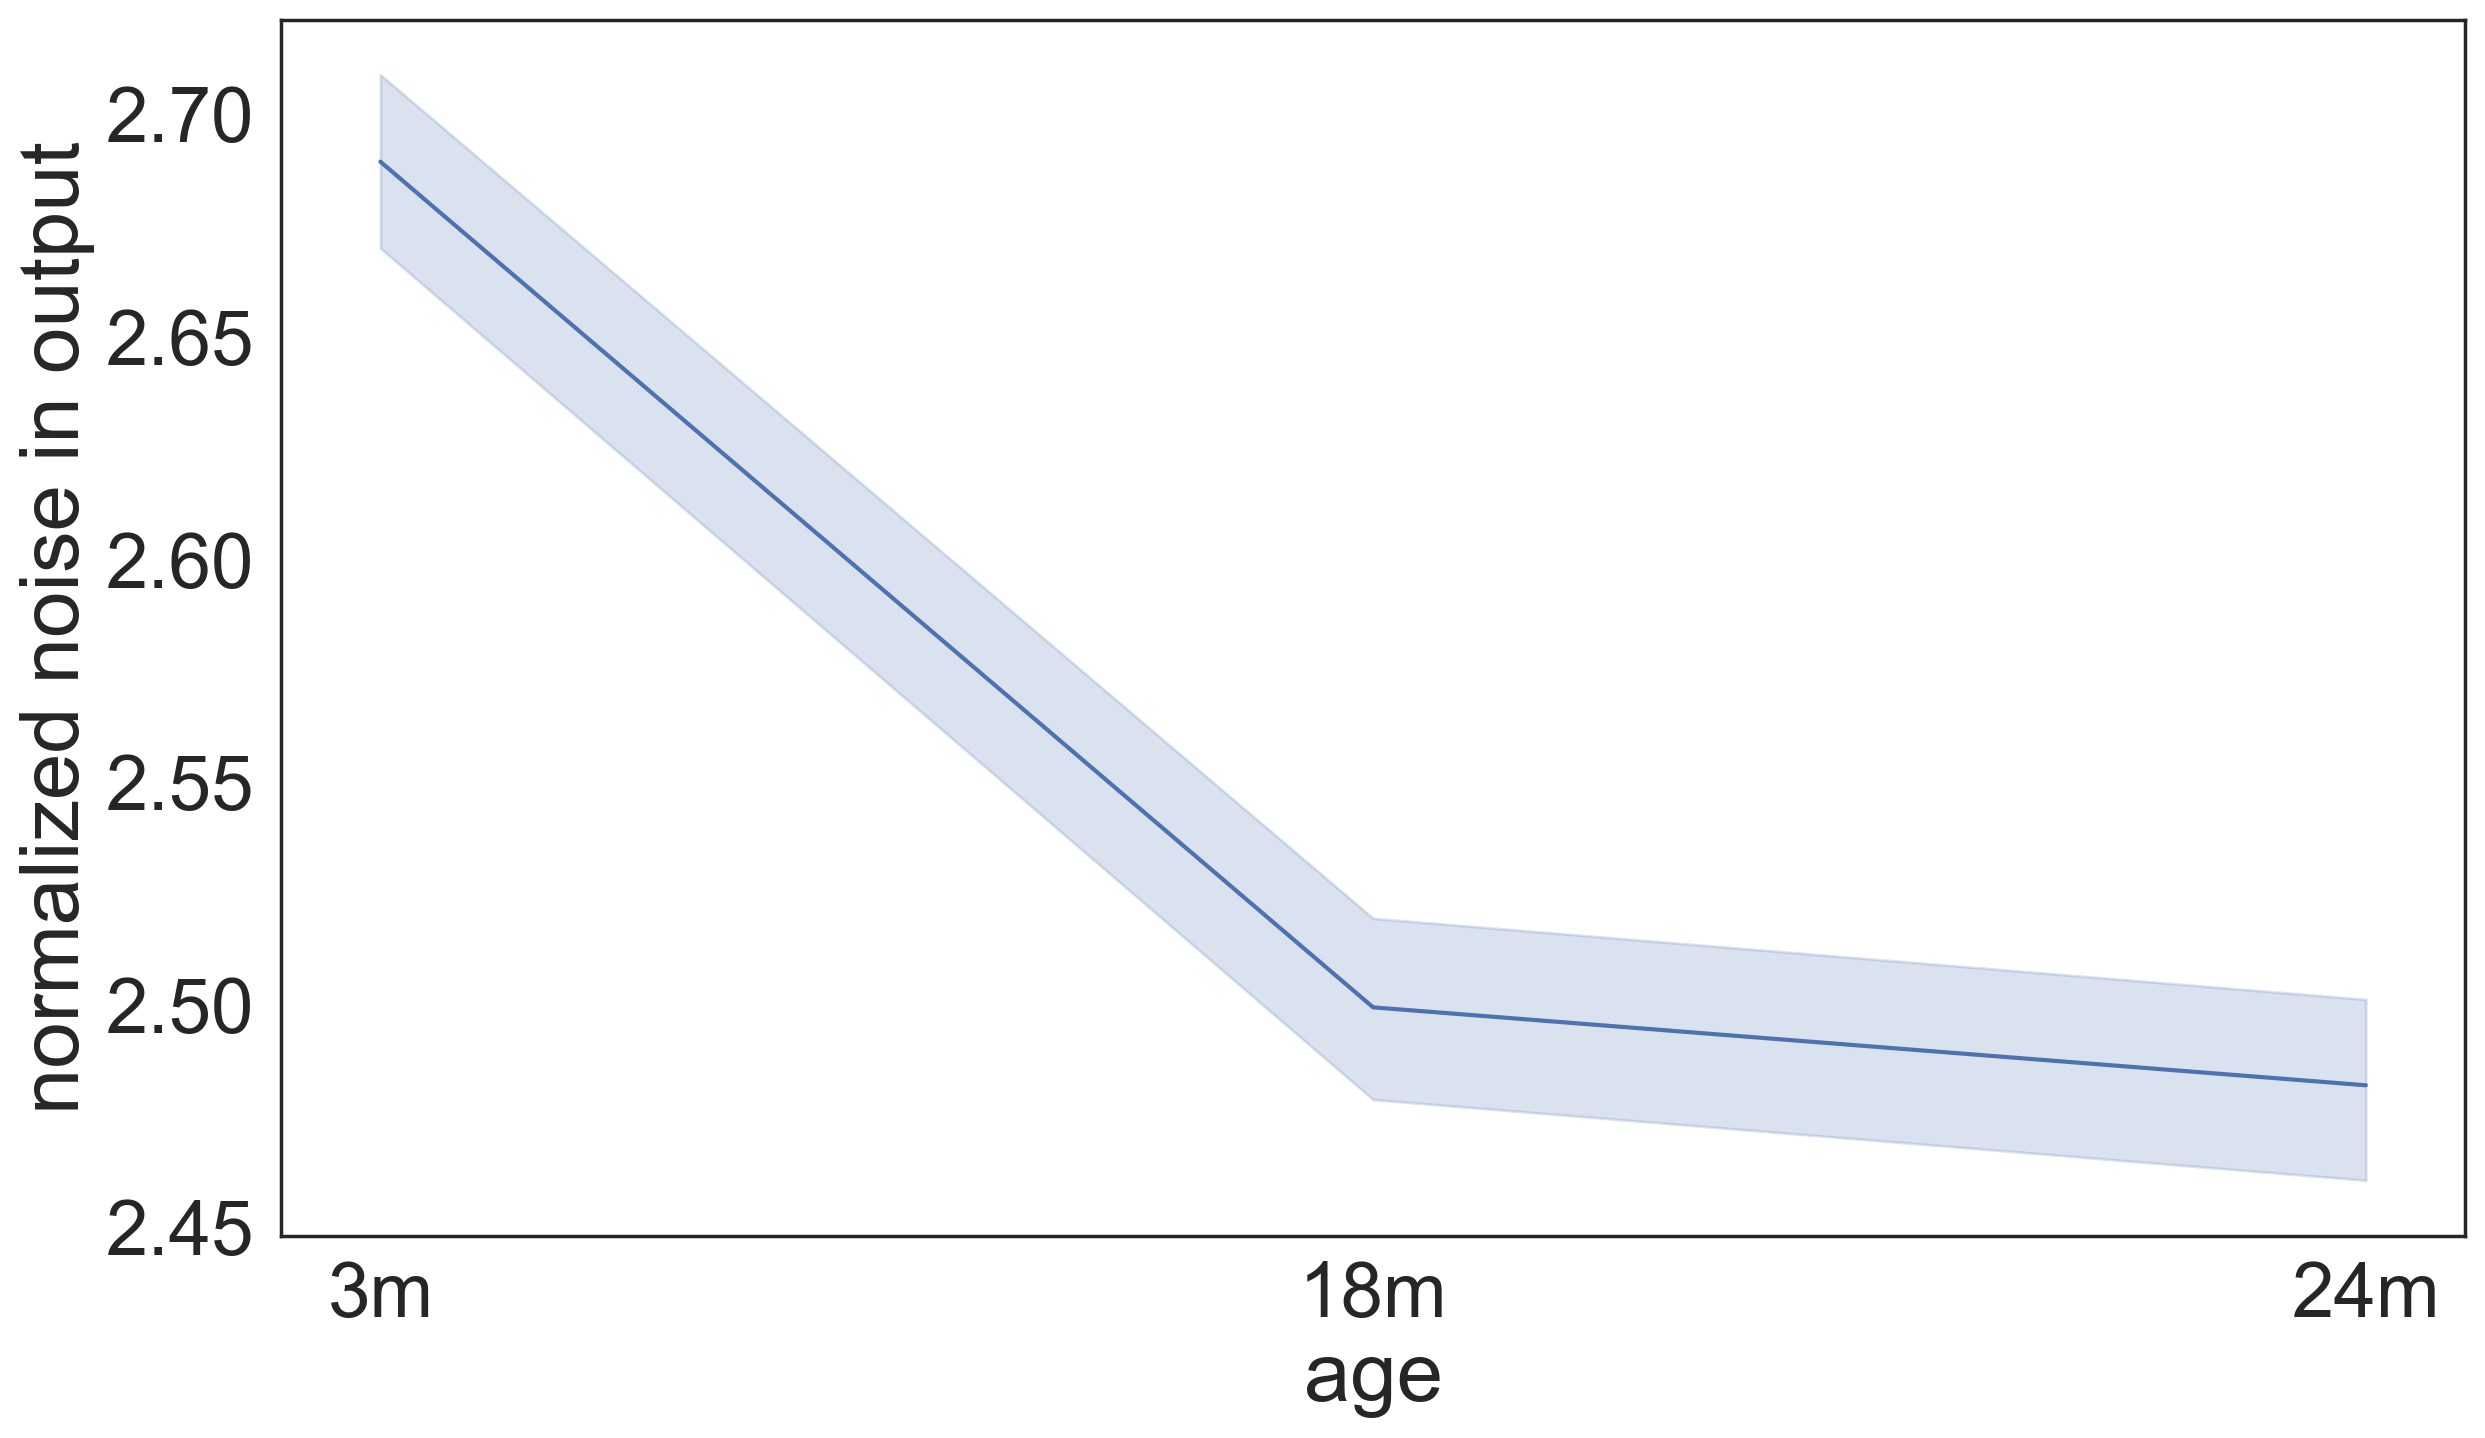

In [77]:
#allcells_df['conditg_per_inputent']= allcells_df['condi_tg|tf_cell'] / allcells_df['entropy_cell_tf']
#allcells_df['conditg_per_inputent']= allcells_df['norm_condi_tg|tf_cell'] / allcells_df['entropy_cell_tf']

sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})


clean_df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
sns.lineplot(data=clean_df, x='age',y='norm_condi_tg|tf_cell')
plt.ylabel('normalized noise in output')

In [78]:
# # It is not necessary to normalize the norm_mi or adj_mi or 
# # even noise with the entropy of input, because it is 
# # already normalized by the product of entropy (input) and entropy(output)

# # dont know why averaging per cell does not work -- zero values of entropy!!!!
# allcells_df['mi_per_inputent']= allcells_df['mi_cell'] / allcells_df['entropy_cell_tf']

Text(0, 0.5, 'normalized useful information')

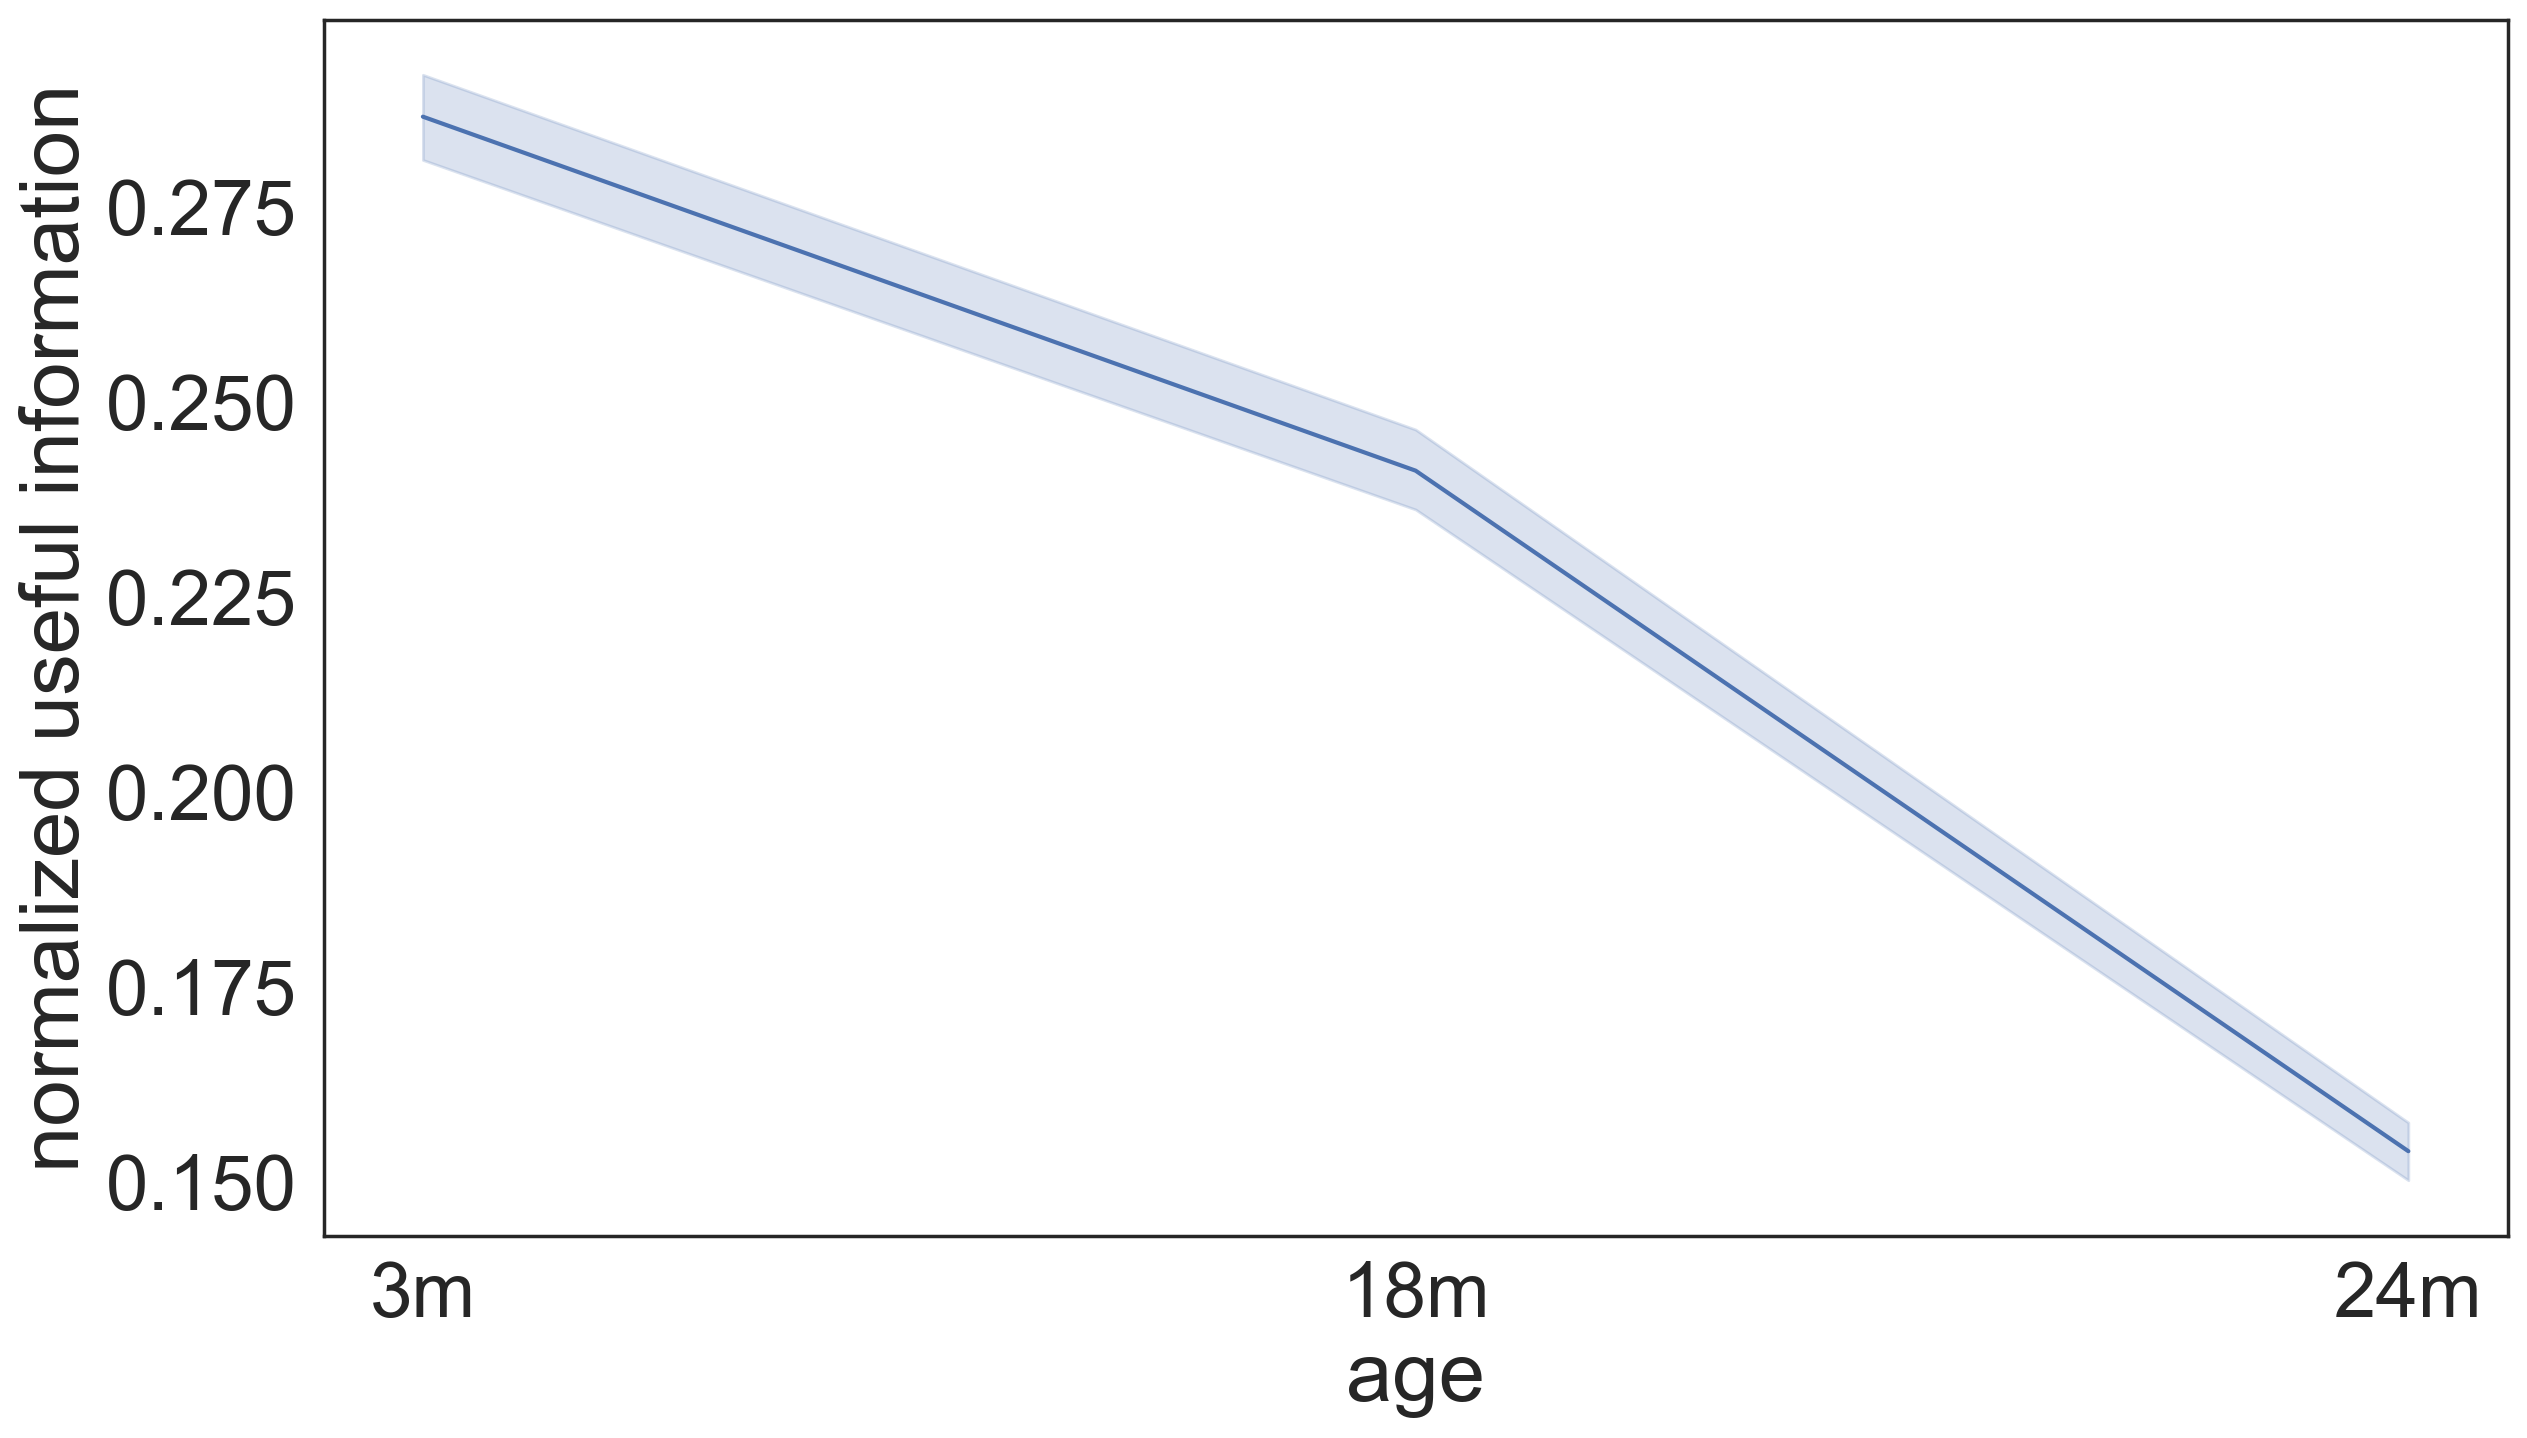

In [80]:
clean_df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

sns.lineplot(data=clean_df, x='age',y='norm_mi_cell')
plt.ylabel('normalized useful information')

Text(0.5, 0, 'MI per cell')

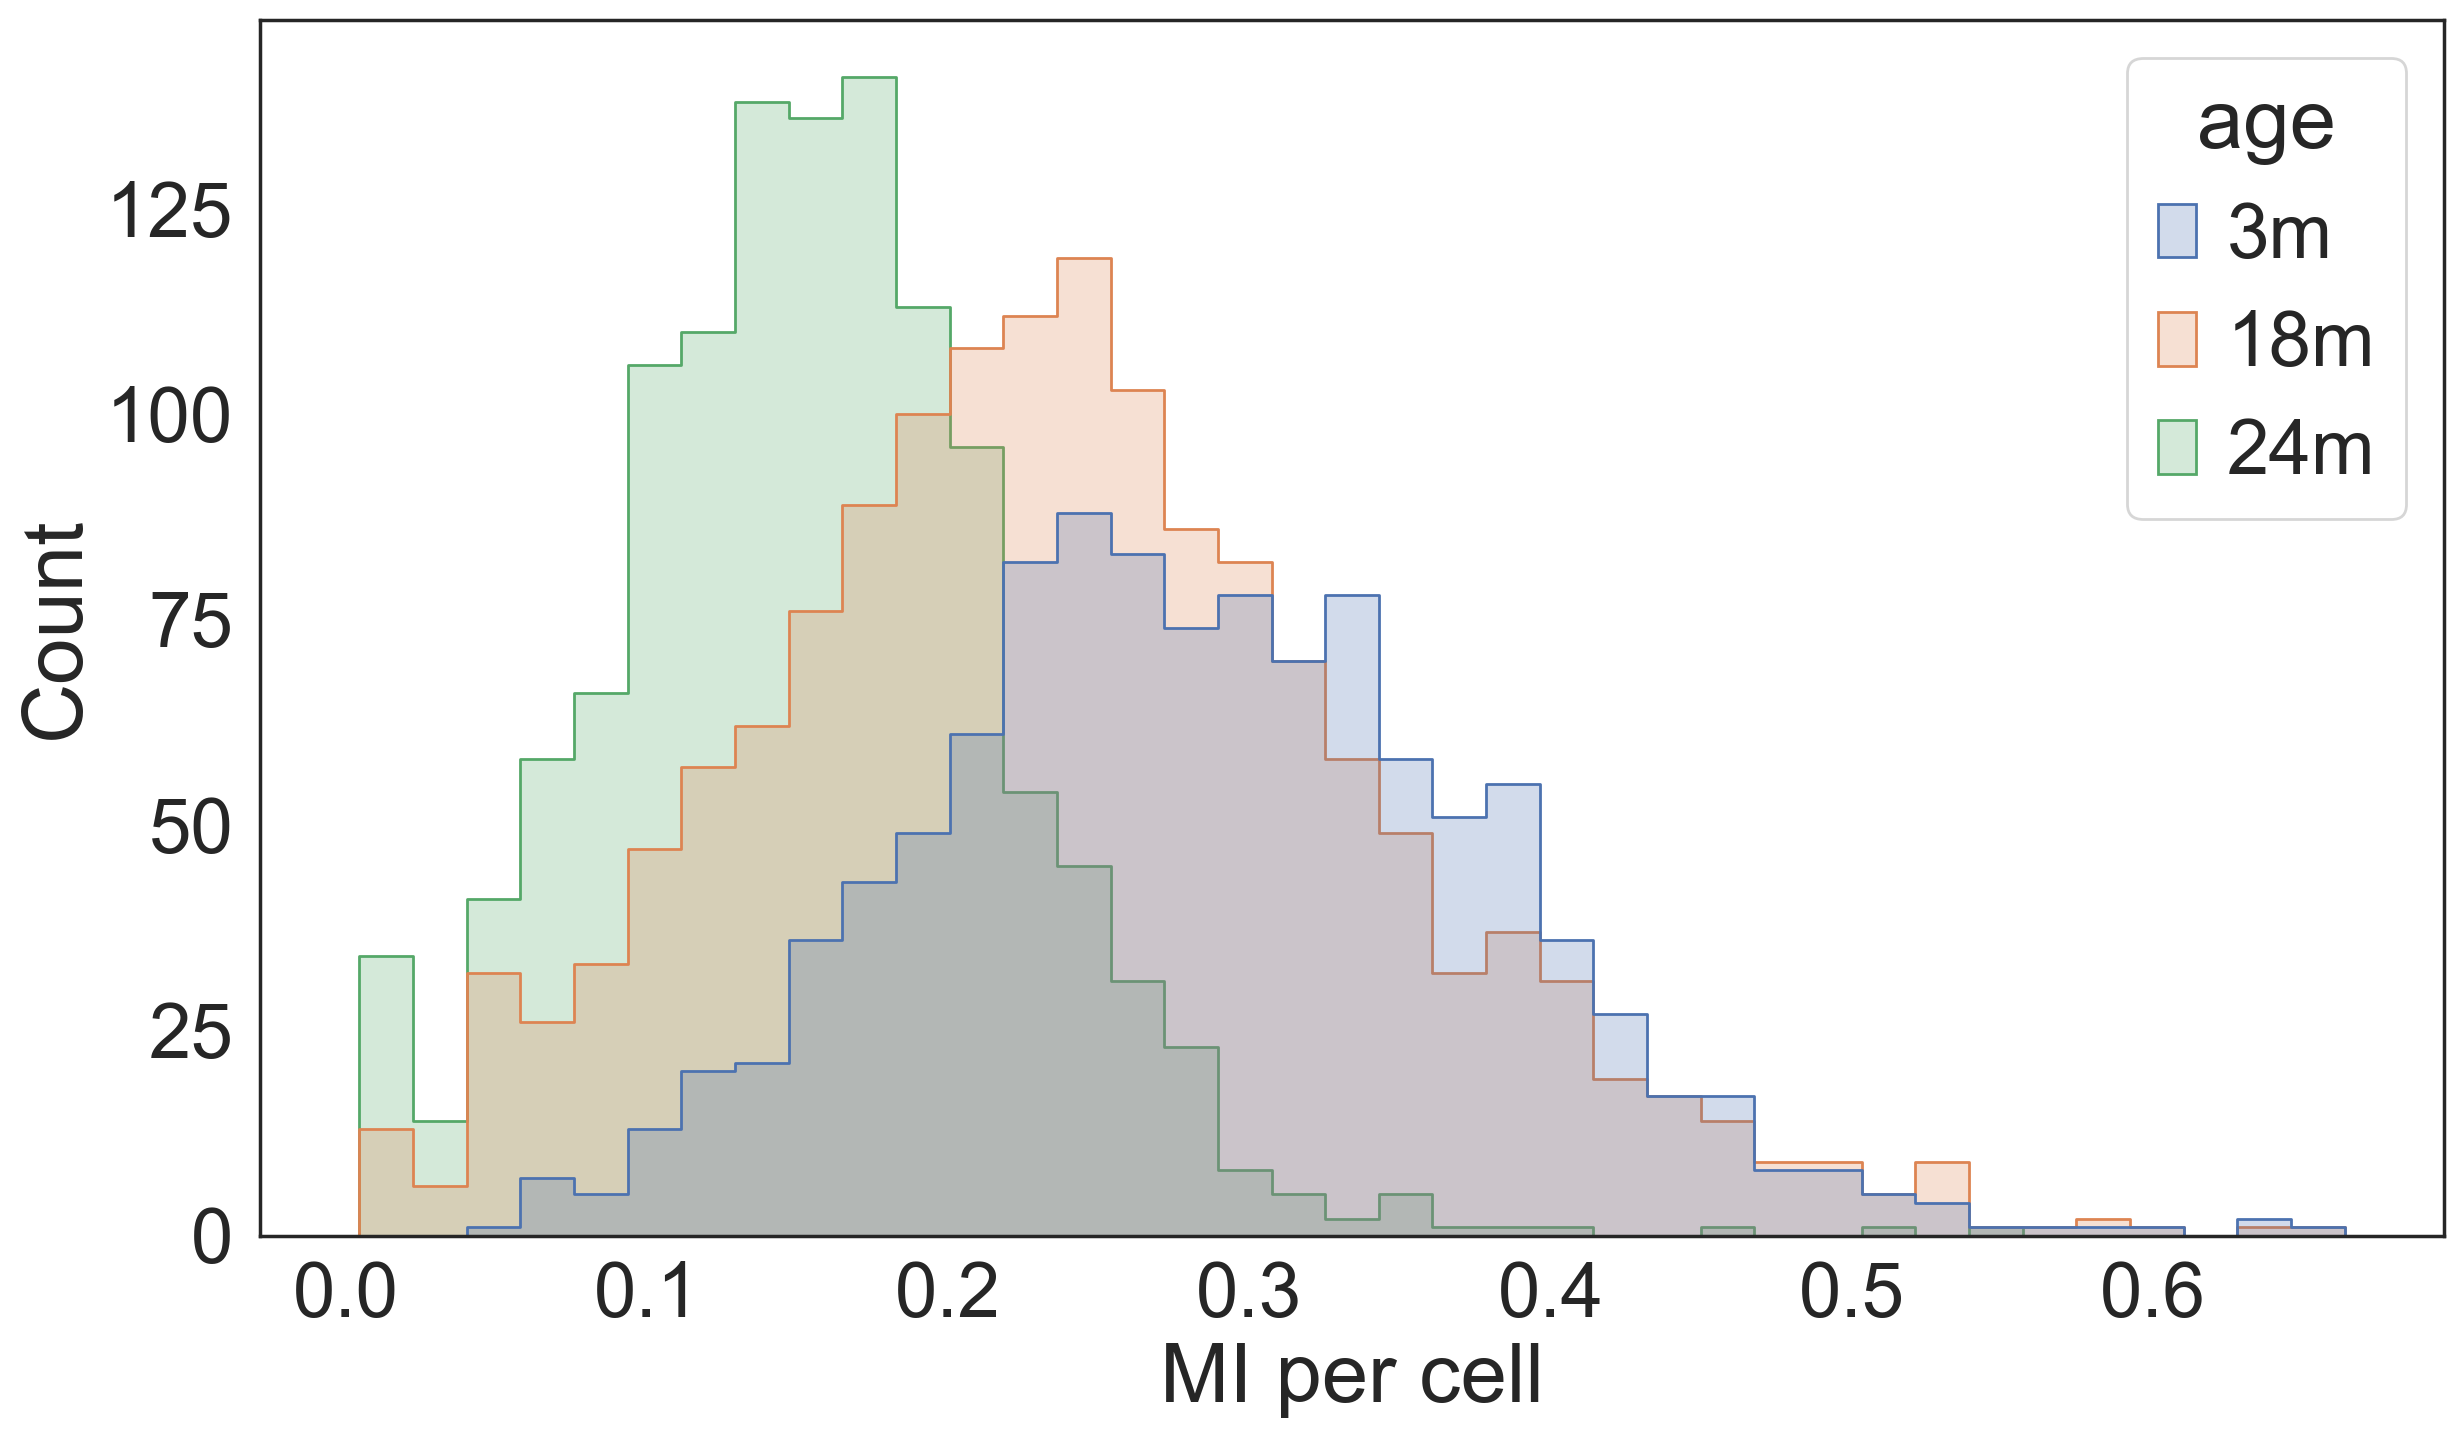

In [86]:
# https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot

sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

sns.histplot(clean_df, x="norm_mi_cell", hue="age", element="step")

plt.xlabel('MI per cell')

Text(0.5, 0, 'Conditional entropy of TG|TF or Noise in output')

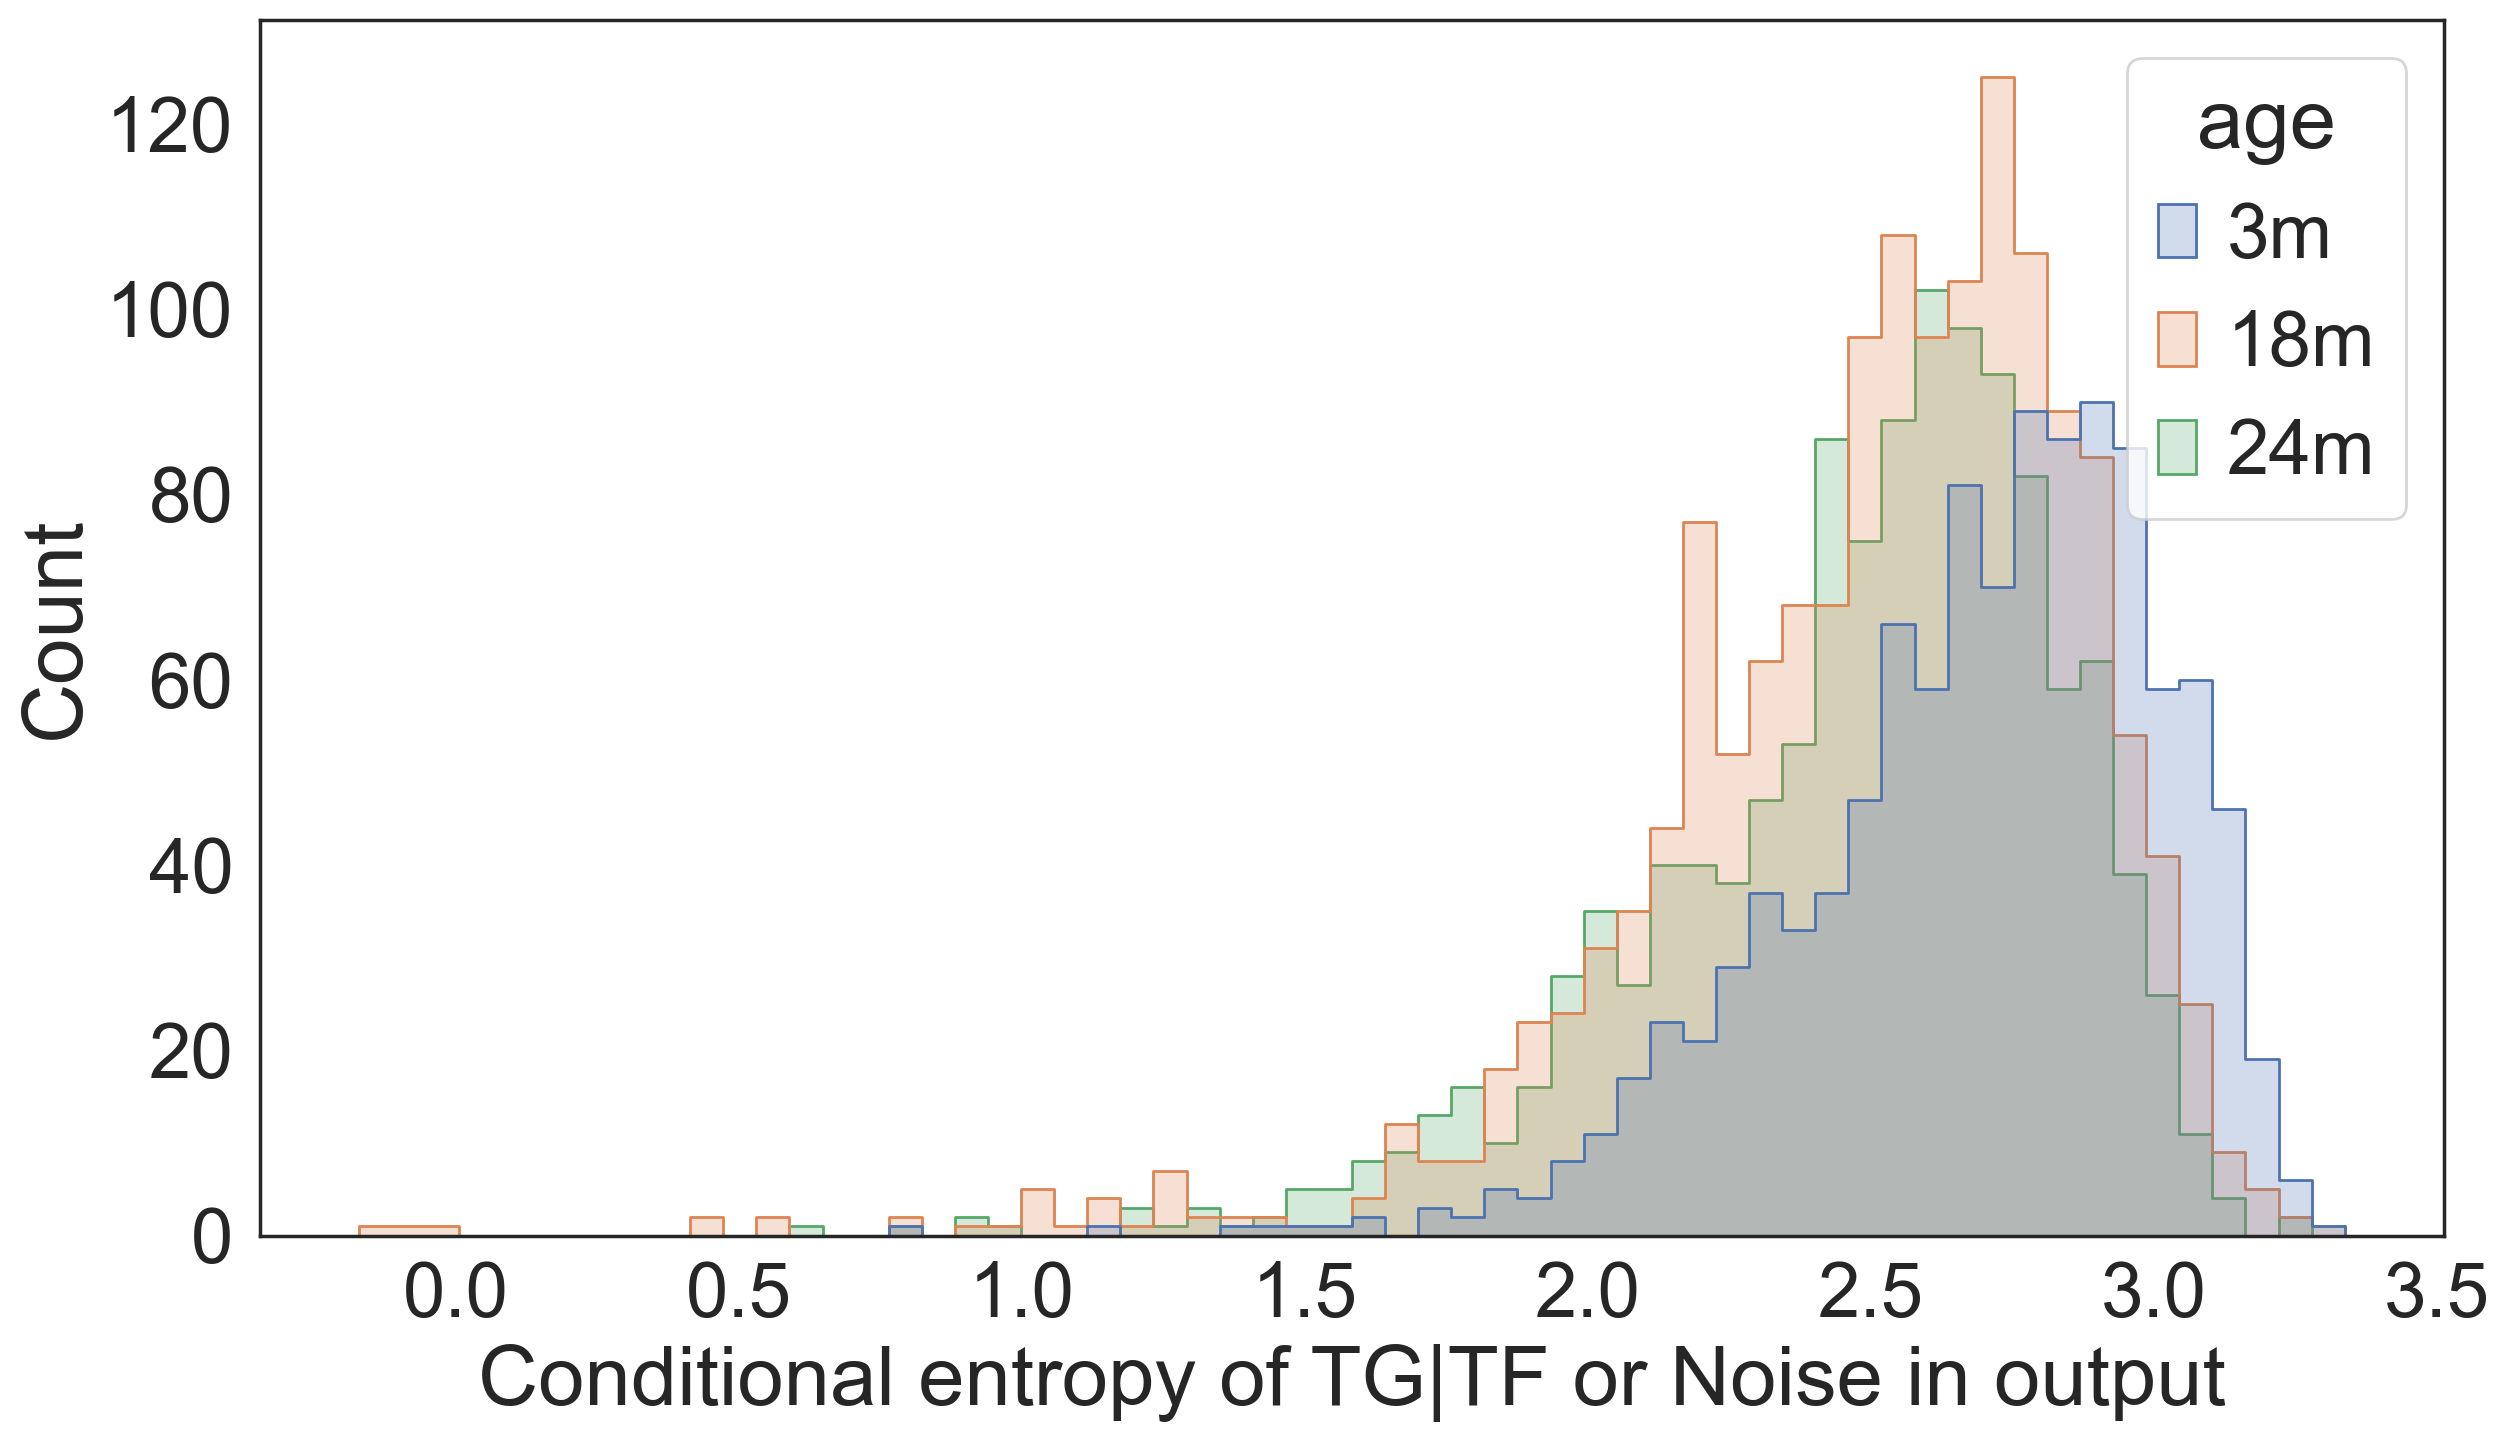

In [87]:
sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

sns.histplot(clean_df, x="norm_condi_tg|tf_cell", hue="age", element="step")

plt.xlabel('Conditional entropy of TG|TF or Noise in output')


# Everything below this is not in figure

# Comparing normalized mutual information and adjusted mutual information

CHECKING DIFFERENT WAYS OF DISCRETIZATION

Normalized mutual information: 
    normalizes by dividing by entropy(input) and entropy(output).

Adjusted mutual information: 
    In addition to normalizing by entropies, it normalizes for chance. As in, the numerator (i.e. mutual info) and denominator (product of entropies) is subtracted by expectation(mutual info).

I found that the nmi may increase as number of clusters in the given list increases. I want to check if that is true for our data with age.

https://scikit-learn.org/stable/modules/clustering.html#mutual-info-score

C:\Users\SRS204\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\SRS204\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

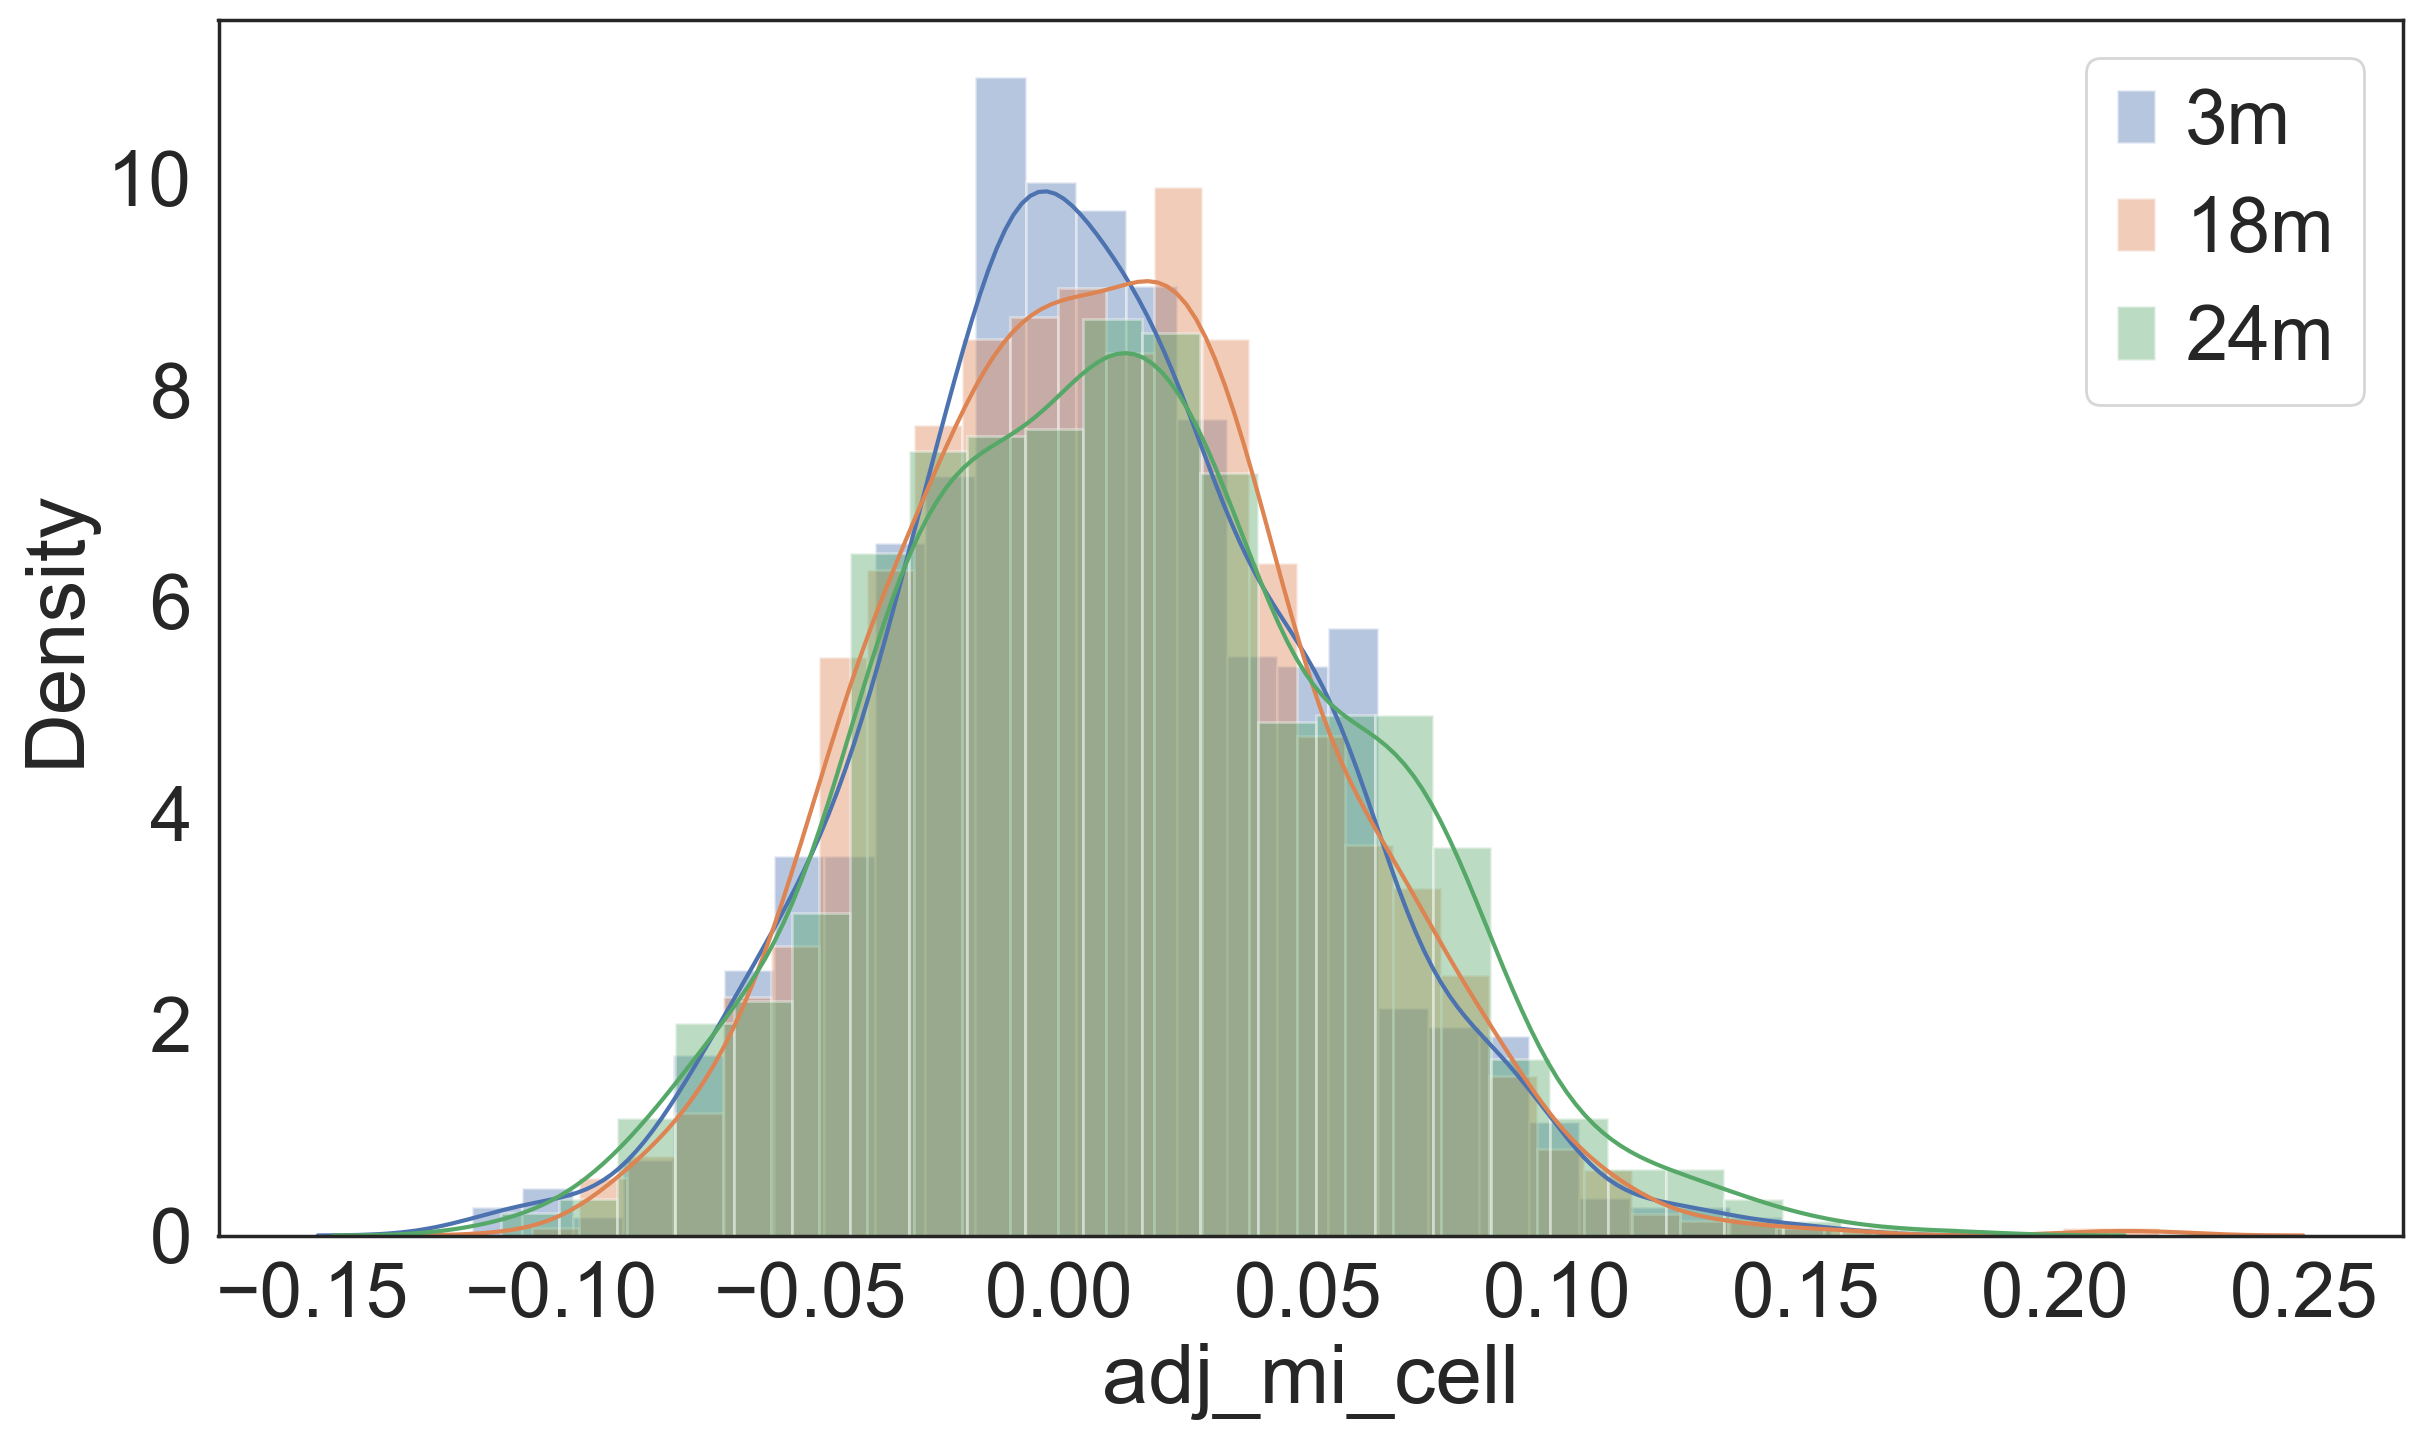

In [71]:
sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

ax=sns.distplot( df[df['age']=='3m']['adj_mi_cell'], label='3m')
ax=sns.distplot( df[df['age']=='18m']['adj_mi_cell'], label='18m')
ax=sns.distplot( df[df['age']=='24m']['adj_mi_cell'], label='24m')
ax.legend()

In [77]:
df.head()

0610007C21Rik  0610007L01Rik  0610007N19Rik  \
A1.B002765.3_38_F.1.1-1-1        1.761105       1.541098            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       1.788955            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       3.050025            0.0   
A10.B002769.3_39_F.1.1-1-1       1.564775       0.000000            0.0   

                            0610007P08Rik  0610007P14Rik  0610007P22Rik  \
A1.B002765.3_38_F.1.1-1-1             0.0            0.0            0.0   
A1.D042103.3_11_M.1-1-1               0.0            0.0            0.0   
A1.D042186.3_8_M.1.1-1-1              0.0            0.0            0.0   
A10.B002765.3_38_F.1.1-1-1            0.0            0.0            0.0   
A10.B002769.3_39_F.1.1-1-1            0.0            0.0            0.0   

                            0610009B22Rik  0610009D07Rik  0610009L18Rik  \
A1.B002765.3_38_F.1.1-1-1        0.000000       0.000000            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       0.384158            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       1.533476            0.0   
A10.B002769.3_39_F.1.1-1-1       2.696855       0.817633            0.0   

                            0610009O20Rik  ...      Zzz3  age  \
A1.B002765.3_38_F.1.1-1-1        0.000000  ...  0.000000   3m   
A1.D042103.3_11_M.1-1-1          0.000000  ...  0.000000   3m   
A1.D042186.3_8_M.1.1-1-1         0.000000  ...  0.289918   3m   
A10.B002765.3_38_F.1.1-1-1       0.000000  ...  0.000000   3m   
A10.B002769.3_39_F.1.1-1-1       1.073734  ...  0.000000   3m   

                            entropy_cell_tf  entropy_cell_tg  norm_mi_cell  \
A1.B002765.3_38_F.1.1-1-1          3.461155         2.787838      0.237433   
A1.D042103.3_11_M.1-1-1            3.248189         2.821225      0.130448   
A1.D042186.3_8_M.1.1-1-1           3.832496         2.964179      0.341543   
A10.B002765.3_38_F.1.1-1-1         3.650747         2.395799      0.239135   
A10.B002769.3_39_F.1.1-1-1         3.560841         2.667208      0.384550   

                            adj_mi_cell  norm_condi_tf|tg_cell  \
A1.B002765.3_38_F.1.1-1-1      0.016711               3.223722   
A1.D042103.3_11_M.1-1-1       -0.033429               3.117741   
A1.D042186.3_8_M.1.1-1-1       0.020705               3.490953   
A10.B002765.3_38_F.1.1-1-1    -0.009651               3.411612   
A10.B002769.3_39_F.1.1-1-1     0.009764               3.176291   

                            norm_condi_tg|tf_cell  adj_condi_tf|tg_cell  \
A1.B002765.3_38_F.1.1-1-1                2.550405              3.444444   
A1.D042103.3_11_M.1-1-1                  2.690777              3.281619   
A1.D042186.3_8_M.1.1-1-1                 2.622636              3.811790   
A10.B002765.3_38_F.1.1-1-1               2.156664              3.660398   
A10.B002769.3_39_F.1.1-1-1               2.282658              3.551077   

                            adj_condi_tg|tf_cell  
A1.B002765.3_38_F.1.1-1-1               2.771127  
A1.D042103.3_11_M.1-1-1                 2.854654  
A1.D042186.3_8_M.1.1-1-1                2.943474  
A10.B002765.3_38_F.1.1-1-1              2.405450  
A10.B002769.3_39_F.1.1-1-1              2.657444  

[5 rows x 10844 columns]

In [81]:
# preserved genes

print("Myc 3m:", len(df[df['age']=='3m']['Myc'].unique()))

print("Zfp36 3m:",len(df[df['age']=='3m']['Zfp36'].unique()))

print("Myc 18m:", len(df[df['age']=='18m']['Myc'].unique()))

print("Zfp36 18m:",len(df[df['age']=='18m']['Zfp36'].unique()))

print("Myc 24m:", len(df[df['age']=='24m']['Myc'].unique()))

print("Zfp36 24m:",len(df[df['age']=='24m']['Zfp36'].unique()))

Myc 3m: 808
Zfp36 3m: 952
Myc 18m: 1048
Zfp36 18m: 1236
Myc 24m: 740
Zfp36 24m: 958


In [82]:
# compromised genes

print("Smad7 3m:", len(df[df['age']=='3m']['Smad7'].unique()))

print("Vegfa 3m:",len(df[df['age']=='3m']['Vegfa'].unique()))

print("Smad7 18m:", len(df[df['age']=='18m']['Smad7'].unique()))

print("Vegfa 18m:",len(df[df['age']=='18m']['Vegfa'].unique()))

print("Smad7 24m:", len(df[df['age']=='24m']['Smad7'].unique()))

print("Vegfa 24m:",len(df[df['age']=='24m']['Vegfa'].unique()))

Smad7 3m: 239
Vegfa 3m: 174
Smad7 18m: 254
Vegfa 18m: 94
Smad7 24m: 134
Vegfa 24m: 37


Calculating normalized and adjusted mi scores after discretization (different bin width)

In [149]:
def nmi_500(df,present_tf_tg_dict):
    '''
    df: dataframe with genes as columns, cells as rows
    present_tf_tg_dict: dictionary of tf and tg - present pairs in the data
    ''' 
    
    nmi_500=[]
    count=0
    
    for cellid, row in df.iterrows():
        
        #cell_tf=pd.cut(row[list(present_tf_tg_dict.keys())], bins=2**np.linspace(0, 15, 100)).sort_index()
        cell_tf=np.digitize(row[list(present_tf_tg_dict.keys())], bins=2**np.linspace(0, 15, 500),right=True)
        
        #cell_tg=pd.cut(row[list(present_tf_tg_dict.values())], bins=2**np.linspace(0, 15, 100)).sort_index()
        cell_tg=np.digitize(row[list(present_tf_tg_dict.values())], bins=2**np.linspace(0, 15, 500),right=True)
        
        try:
            nmi_500.append(normalized_mutual_info_score(cell_tf,cell_tg))
        except:
            count+=1
            
    return nmi_500,count          

In [150]:
def nmi_50(df,present_tf_tg_dict):
    '''
    df: dataframe with genes as columns, cells as rows
    present_tf_tg_dict: dictionary of tf and tg - present pairs in the data
    ''' 
    
    nmi_50=[]
    count=0
    
    for cellid, row in df.iterrows():
        
        #cell_tf=pd.cut(row[list(present_tf_tg_dict.keys())], bins=2**np.linspace(0, 15, 100)).sort_index()
        cell_tf=np.digitize(row[list(present_tf_tg_dict.keys())], bins=2**np.linspace(0, 15, 50),right=True)
        
        #cell_tg=pd.cut(row[list(present_tf_tg_dict.values())], bins=2**np.linspace(0, 15, 100)).sort_index()
        cell_tg=np.digitize(row[list(present_tf_tg_dict.values())], bins=2**np.linspace(0, 15, 50),right=True)
        
        try:
            nmi_50.append(normalized_mutual_info_score(cell_tf,cell_tg))
        except:
            count+=1
            
    return nmi_50,count          

In [151]:
# 3m nmi_500
values_only_df=(df).iloc[: , :-9]

values_only_df.head()


0610007C21Rik  0610007L01Rik  0610007N19Rik  \
A1.B002765.3_38_F.1.1-1-1        1.761105       1.541098            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       1.788955            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       3.050025            0.0   
A10.B002769.3_39_F.1.1-1-1       1.564775       0.000000            0.0   

                            0610007P08Rik  0610007P14Rik  0610007P22Rik  \
A1.B002765.3_38_F.1.1-1-1             0.0            0.0            0.0   
A1.D042103.3_11_M.1-1-1               0.0            0.0            0.0   
A1.D042186.3_8_M.1.1-1-1              0.0            0.0            0.0   
A10.B002765.3_38_F.1.1-1-1            0.0            0.0            0.0   
A10.B002769.3_39_F.1.1-1-1            0.0            0.0            0.0   

                            0610009B22Rik  0610009D07Rik  0610009L18Rik  \
A1.B002765.3_38_F.1.1-1-1        0.000000       0.000000            0.0   
A1.D042103.3_11_M.1-1-1          0.000000       0.000000            0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000       0.384158            0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000       1.533476            0.0   
A10.B002769.3_39_F.1.1-1-1       2.696855       0.817633            0.0   

                            0610009O20Rik  ...    Zswim6    Zswim7  Zufsp  \
A1.B002765.3_38_F.1.1-1-1        0.000000  ...  0.000000  0.000000    0.0   
A1.D042103.3_11_M.1-1-1          0.000000  ...  6.832855  0.000000    0.0   
A1.D042186.3_8_M.1.1-1-1         0.000000  ...  3.882913  0.000000    0.0   
A10.B002765.3_38_F.1.1-1-1       0.000000  ...  0.000000  0.000000    0.0   
A10.B002769.3_39_F.1.1-1-1       1.073734  ...  0.000000  1.812647    0.0   

                            Zw10     Zwint  Zxdc    Zyg11b       Zyx  \
A1.B002765.3_38_F.1.1-1-1    0.0  1.522642   0.0  0.000000  1.806709   
A1.D042103.3_11_M.1-1-1      0.0  0.000000   0.0  0.000000  0.000000   
A1.D042186.3_8_M.1.1-1-1     0.0  0.000000   0.0  0.161871  1.352870   
A10.B002765.3_38_F.1.1-1-1   0.0  0.025267   0.0  0.000000  0.000000   
A10.B002769.3_39_F.1.1-1-1   0.0  0.000000   0.0  0.029860  0.719527   

                               Zzef1      Zzz3  
A1.B002765.3_38_F.1.1-1-1   0.000000  0.000000  
A1.D042103.3_11_M.1-1-1     0.000000  0.000000  
A1.D042186.3_8_M.1.1-1-1    1.701163  0.289918  
A10.B002765.3_38_F.1.1-1-1  0.000000  0.000000  
A10.B002769.3_39_F.1.1-1-1  0.024443  0.000000  

[5 rows x 10835 columns]

In [152]:
#print(nmi_500)
nmi_50,count = nmi_50(values_only_df, present_tf_tg_dict)

In [153]:
#values_only_df.isna().sum().sum()

nmi_500,count = nmi_500(values_only_df, present_tf_tg_dict)
#print(nmi_500)

In [154]:
values_only_df['age']=df['age']
values_only_df['nmi_500']=nmi_500

C:\Users\Sruthi Sivakumar\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


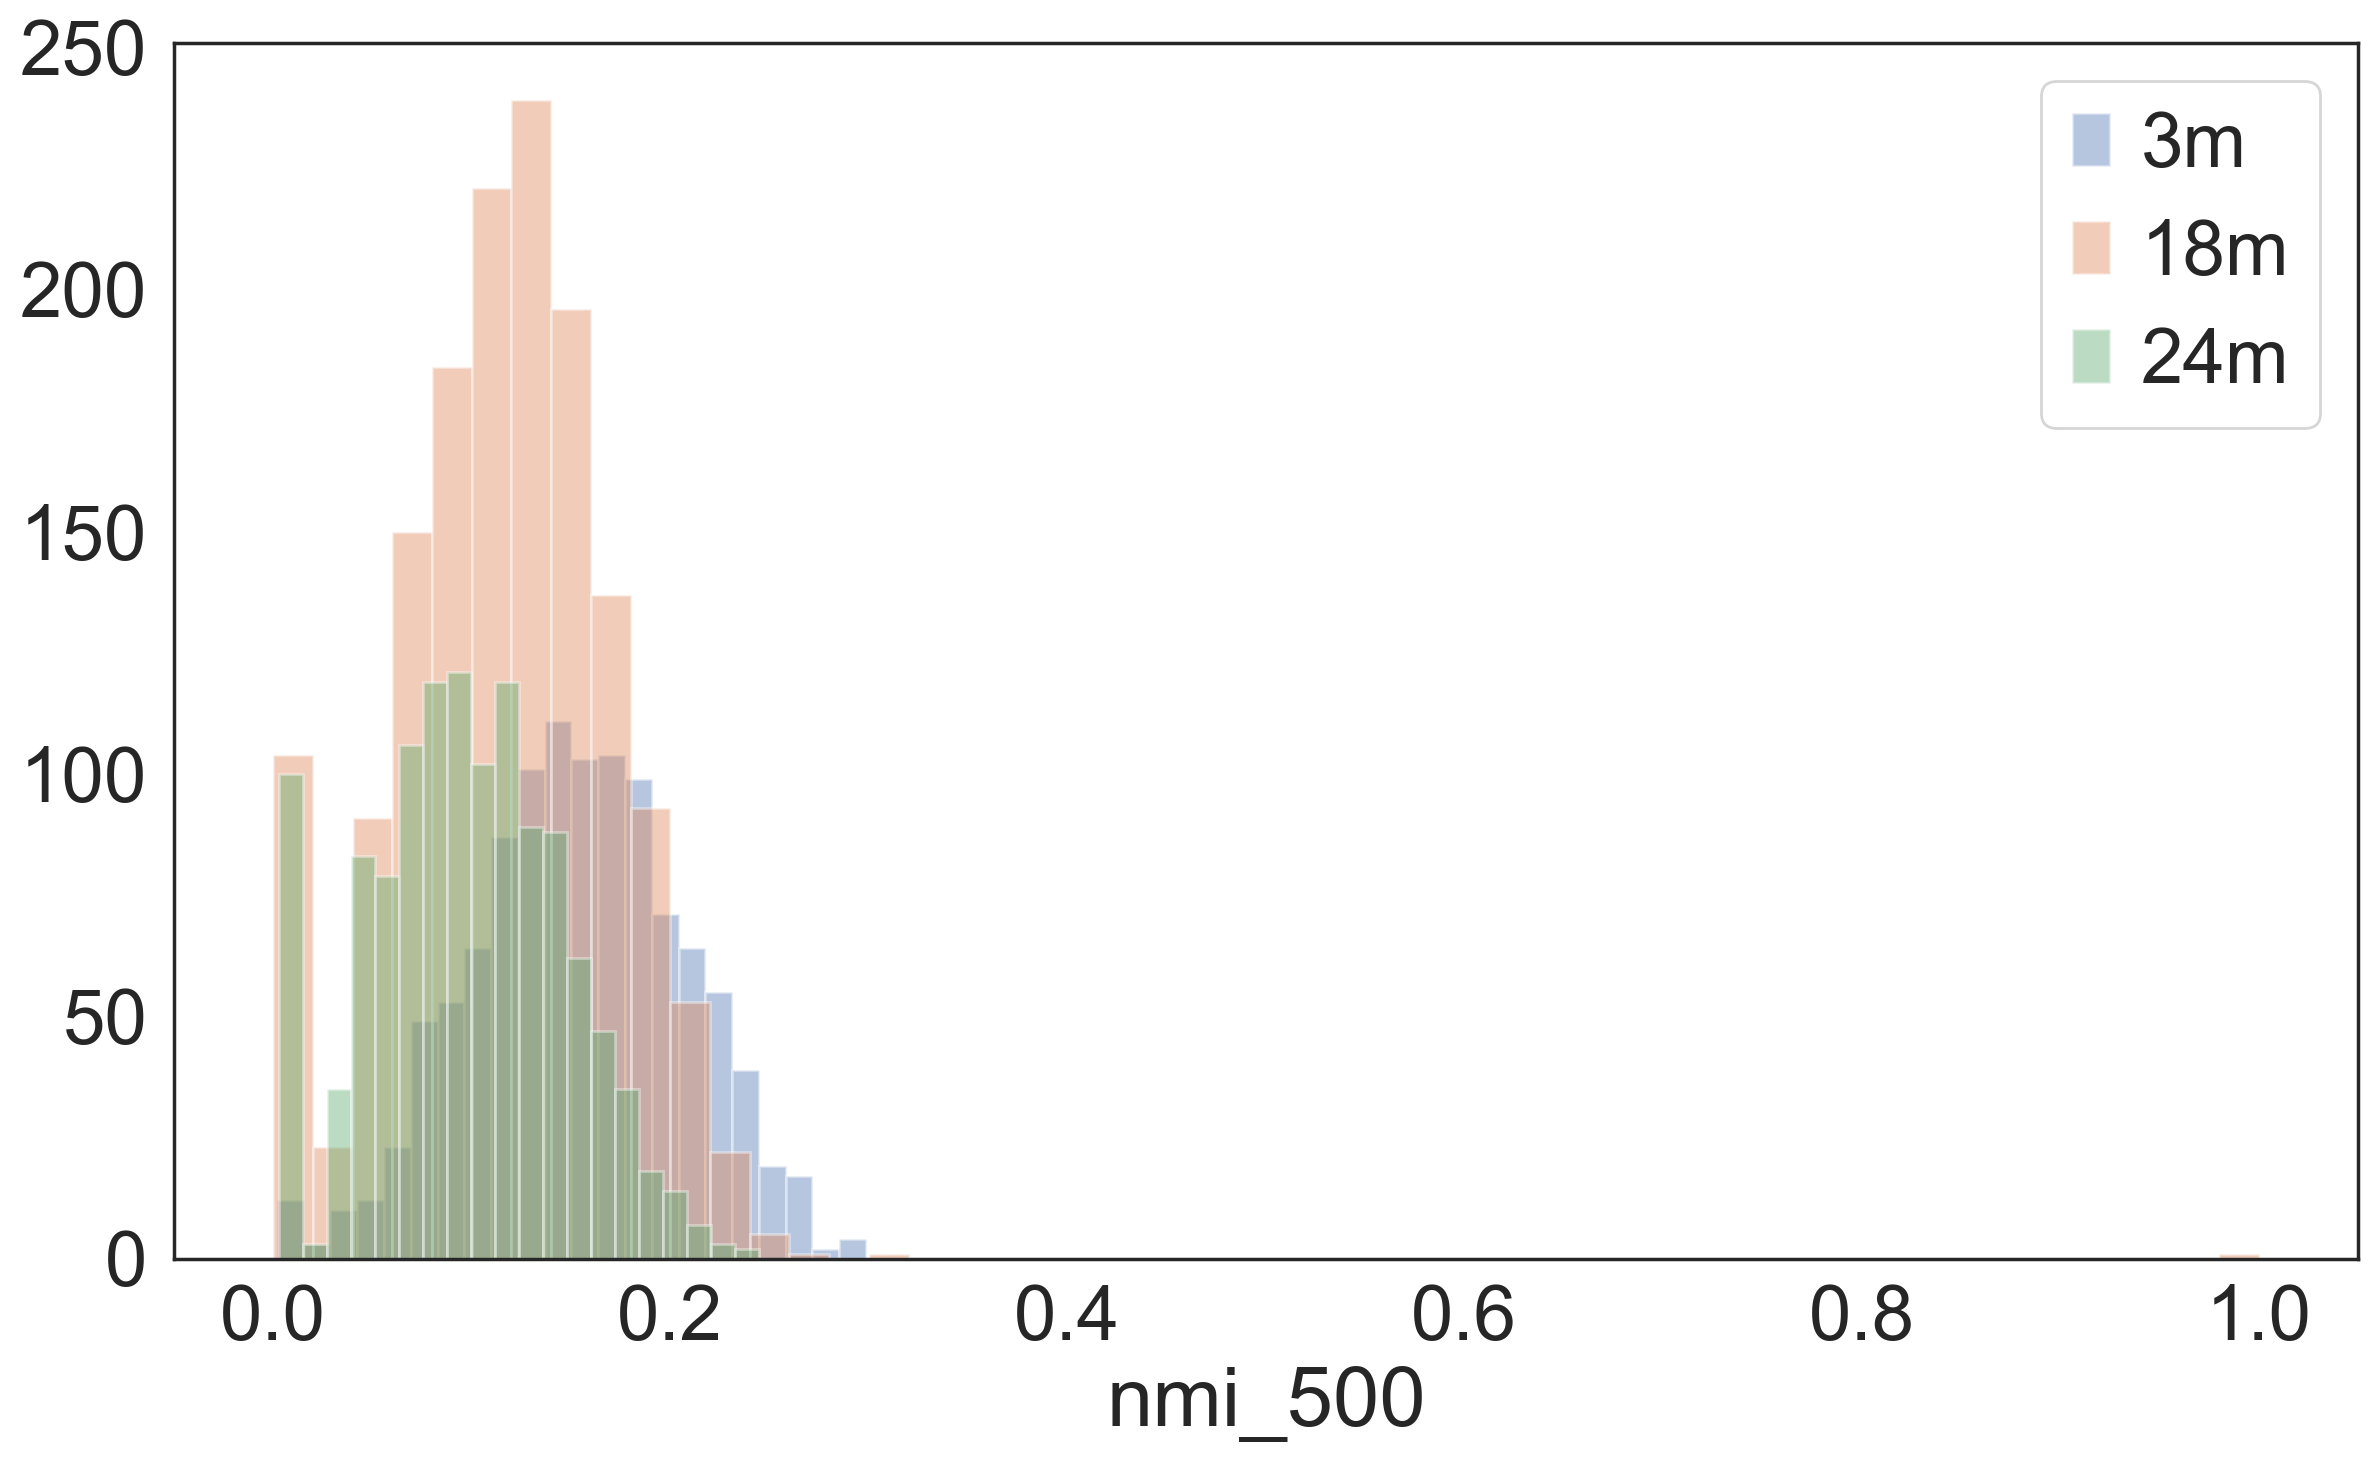

In [125]:
sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

ax=sns.distplot( values_only_df[values_only_df['age']=='3m']['nmi_500'], label='3m',kde=False)
ax=sns.distplot( values_only_df[values_only_df['age']=='18m']['nmi_500'], label='18m',kde=False)
ax=sns.distplot( values_only_df[values_only_df['age']=='24m']['nmi_500'], label='24m',kde=False)
ax.legend()

C:\Users\Sruthi Sivakumar\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


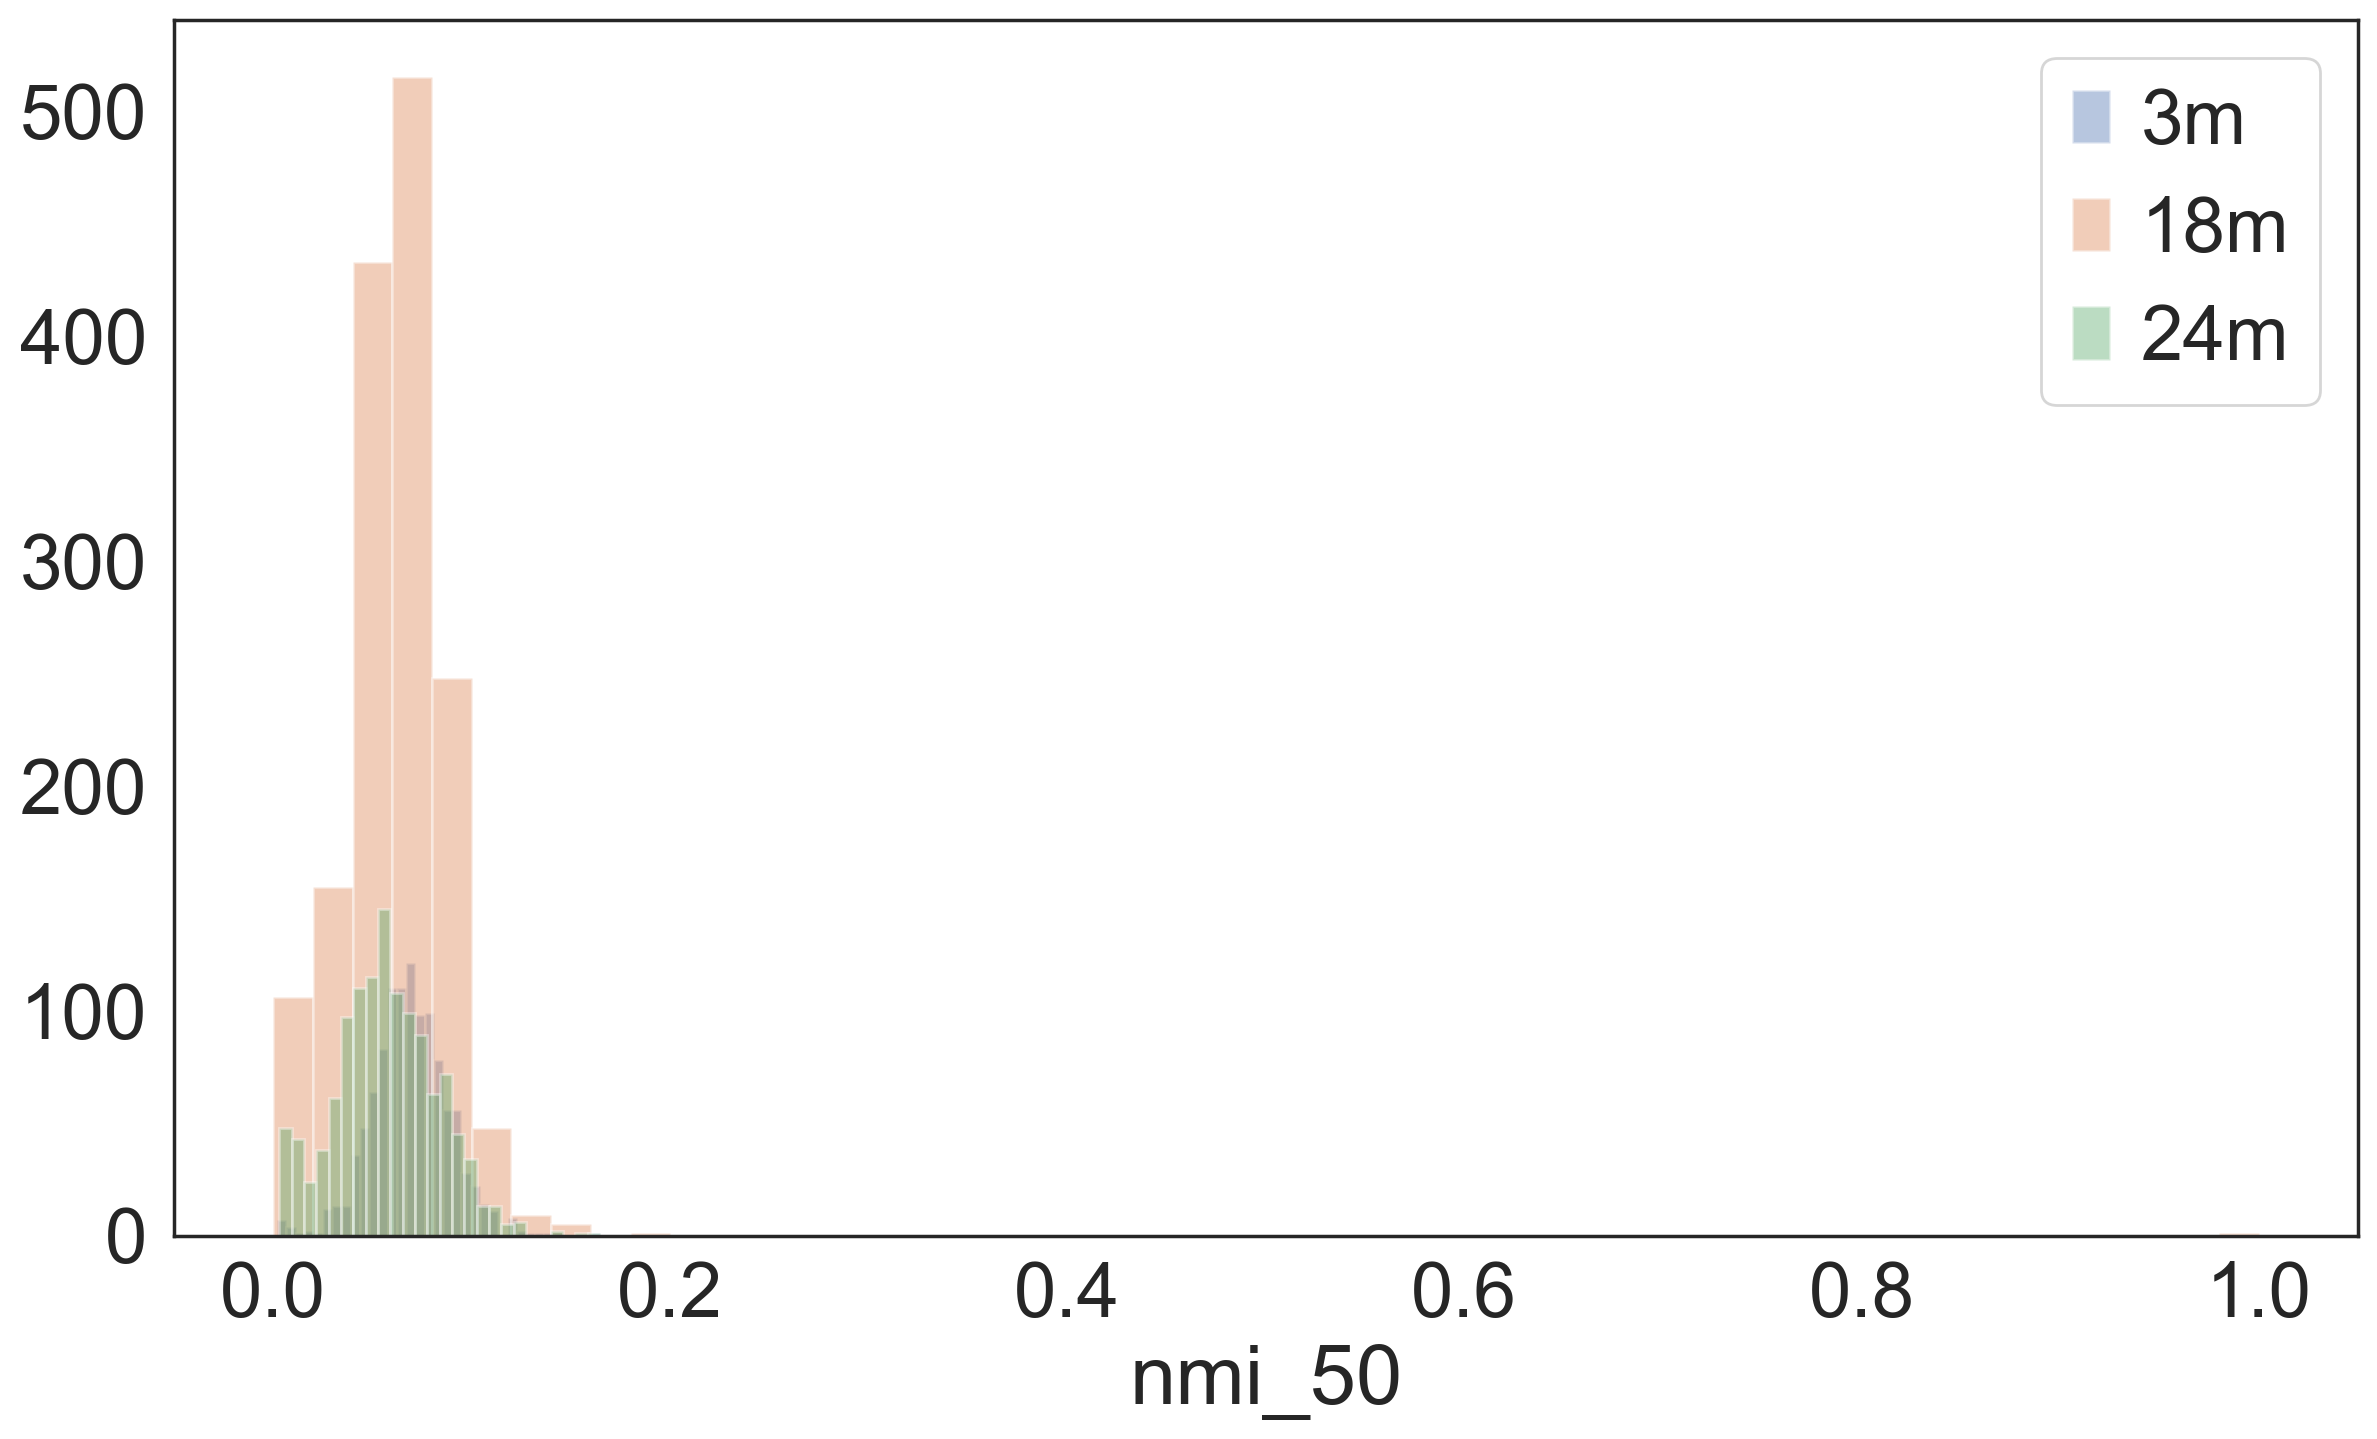

In [130]:
values_only_df['nmi_50']=nmi_50

sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

ax=sns.distplot( values_only_df[values_only_df['age']=='3m']['nmi_50'], label='3m',kde=False)
ax=sns.distplot( values_only_df[values_only_df['age']=='18m']['nmi_50'], label='18m',kde=False)
ax=sns.distplot( values_only_df[values_only_df['age']=='24m']['nmi_50'], label='24m',kde=False)
ax.legend()

Text(0, 0.5, 'useful information_nmi500')

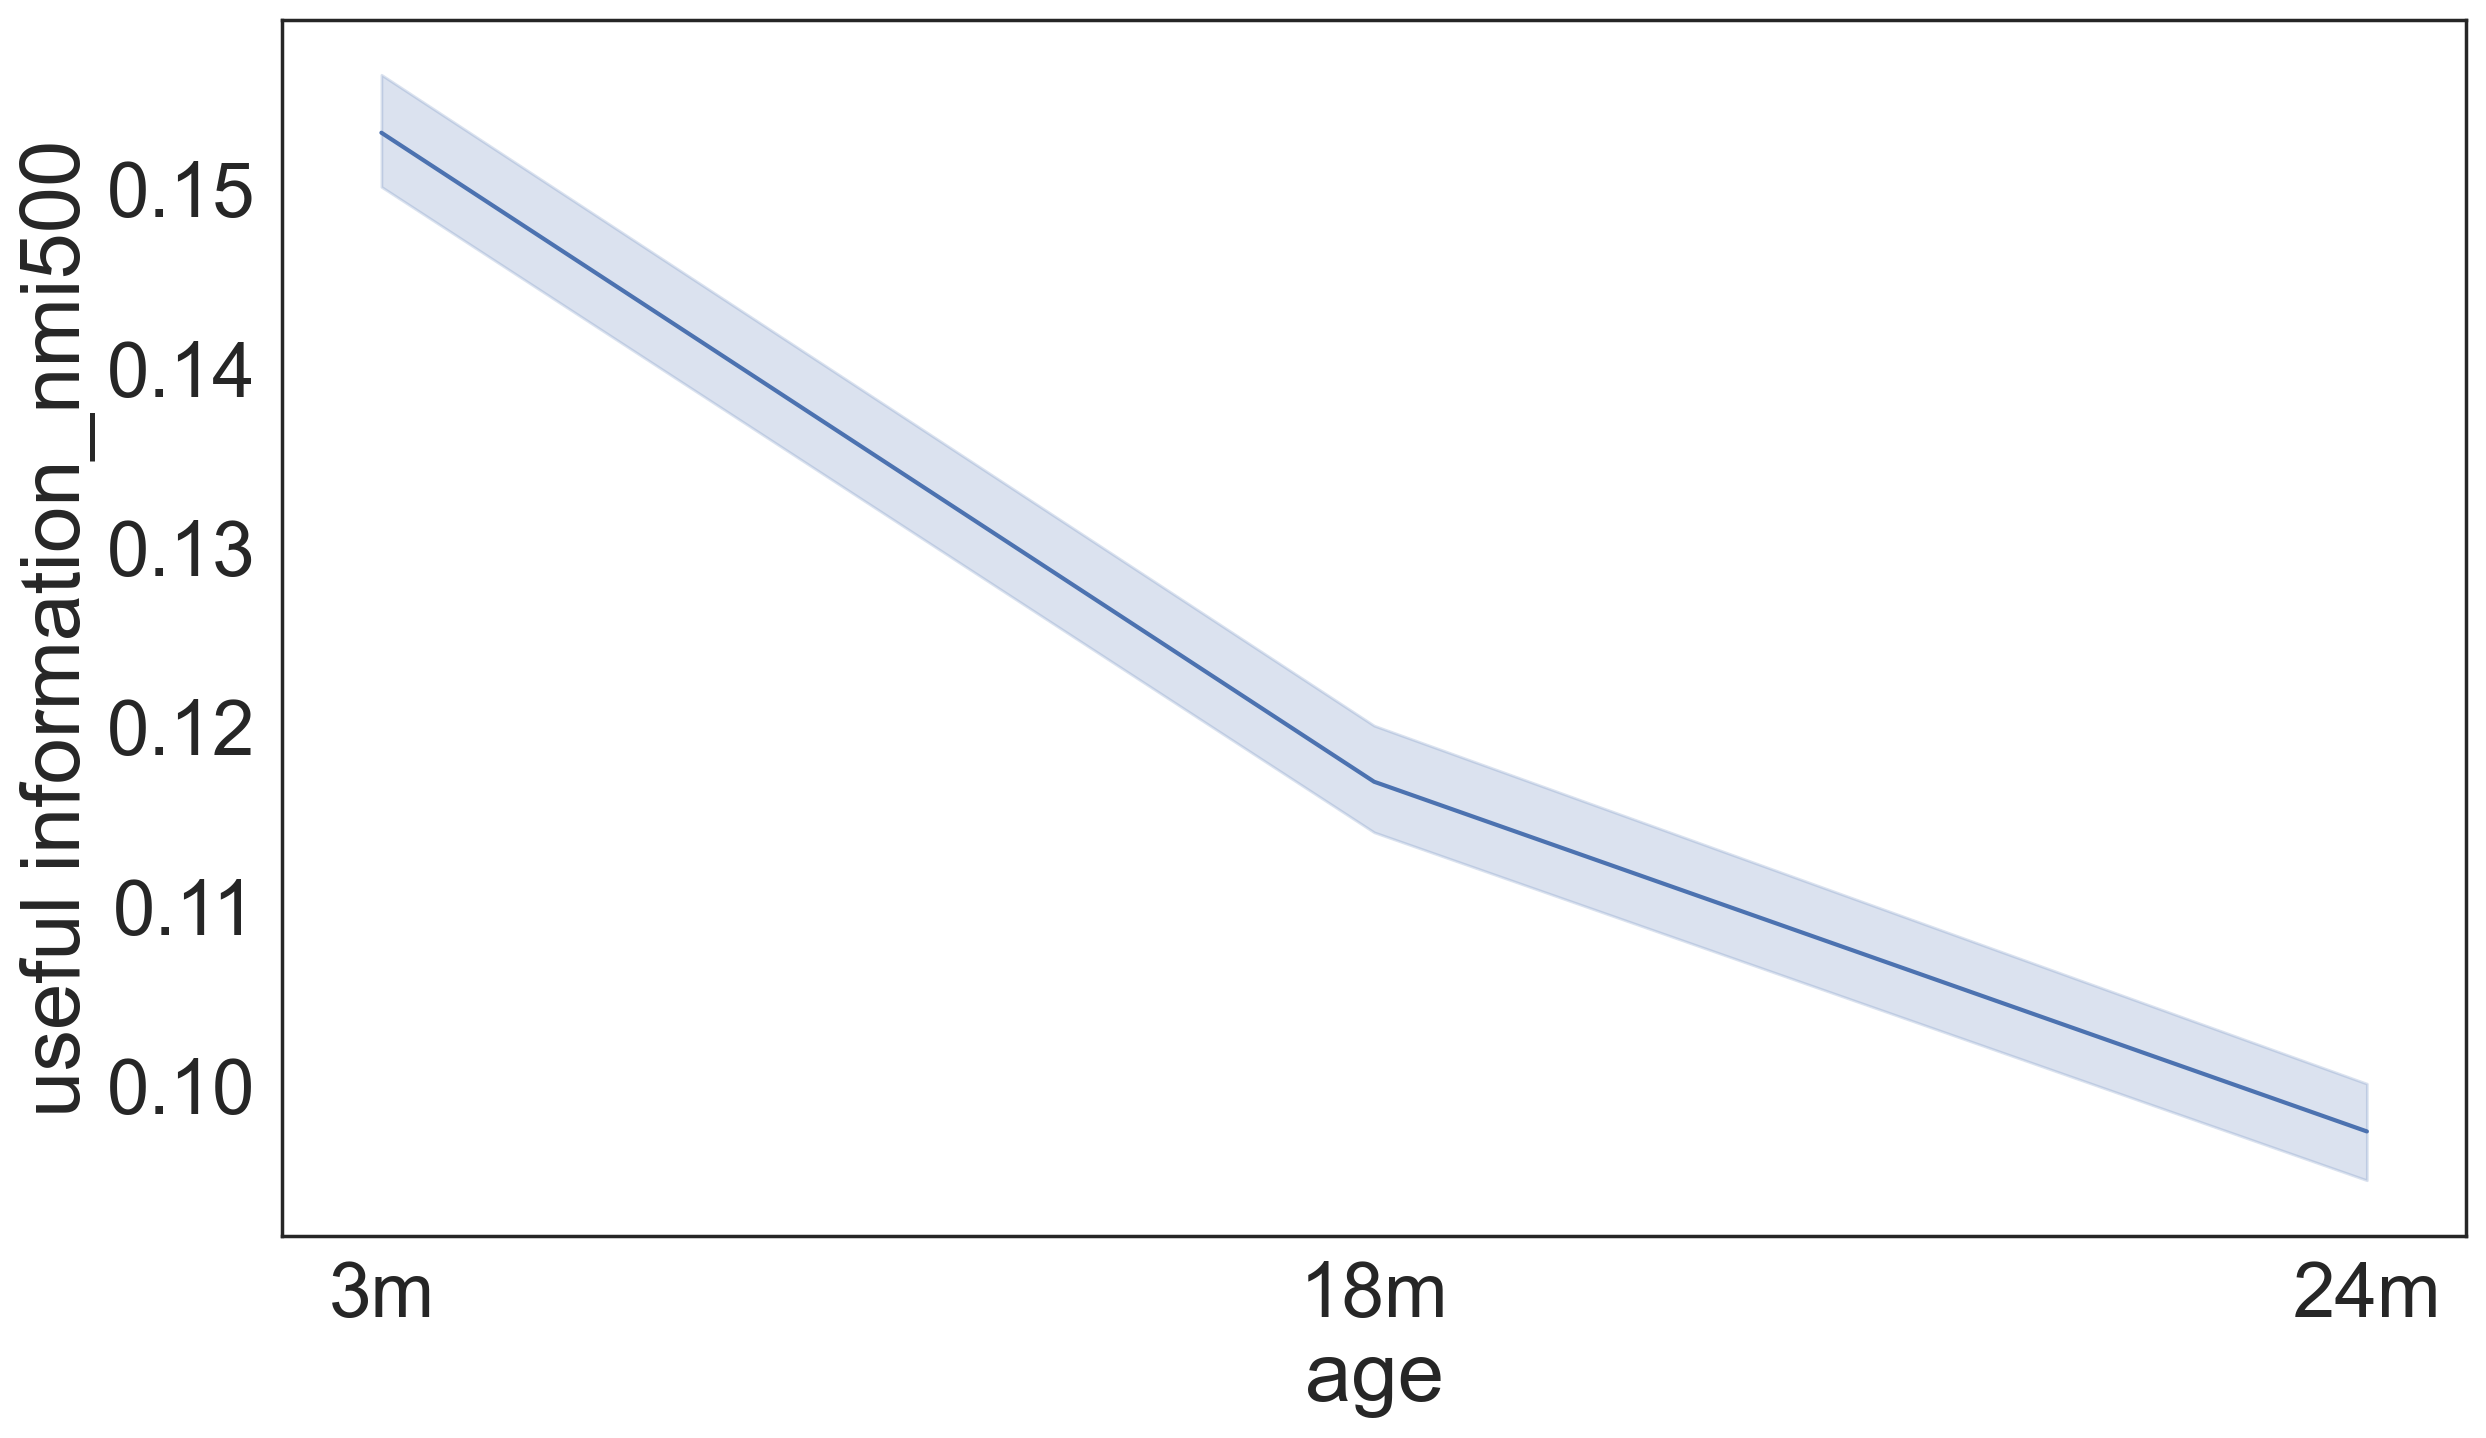

In [155]:
sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

sns.lineplot(data=values_only_df, x='age',y='nmi_500')
plt.ylabel('useful information_nmi500')

Text(0, 0.5, 'useful information_nmi50')

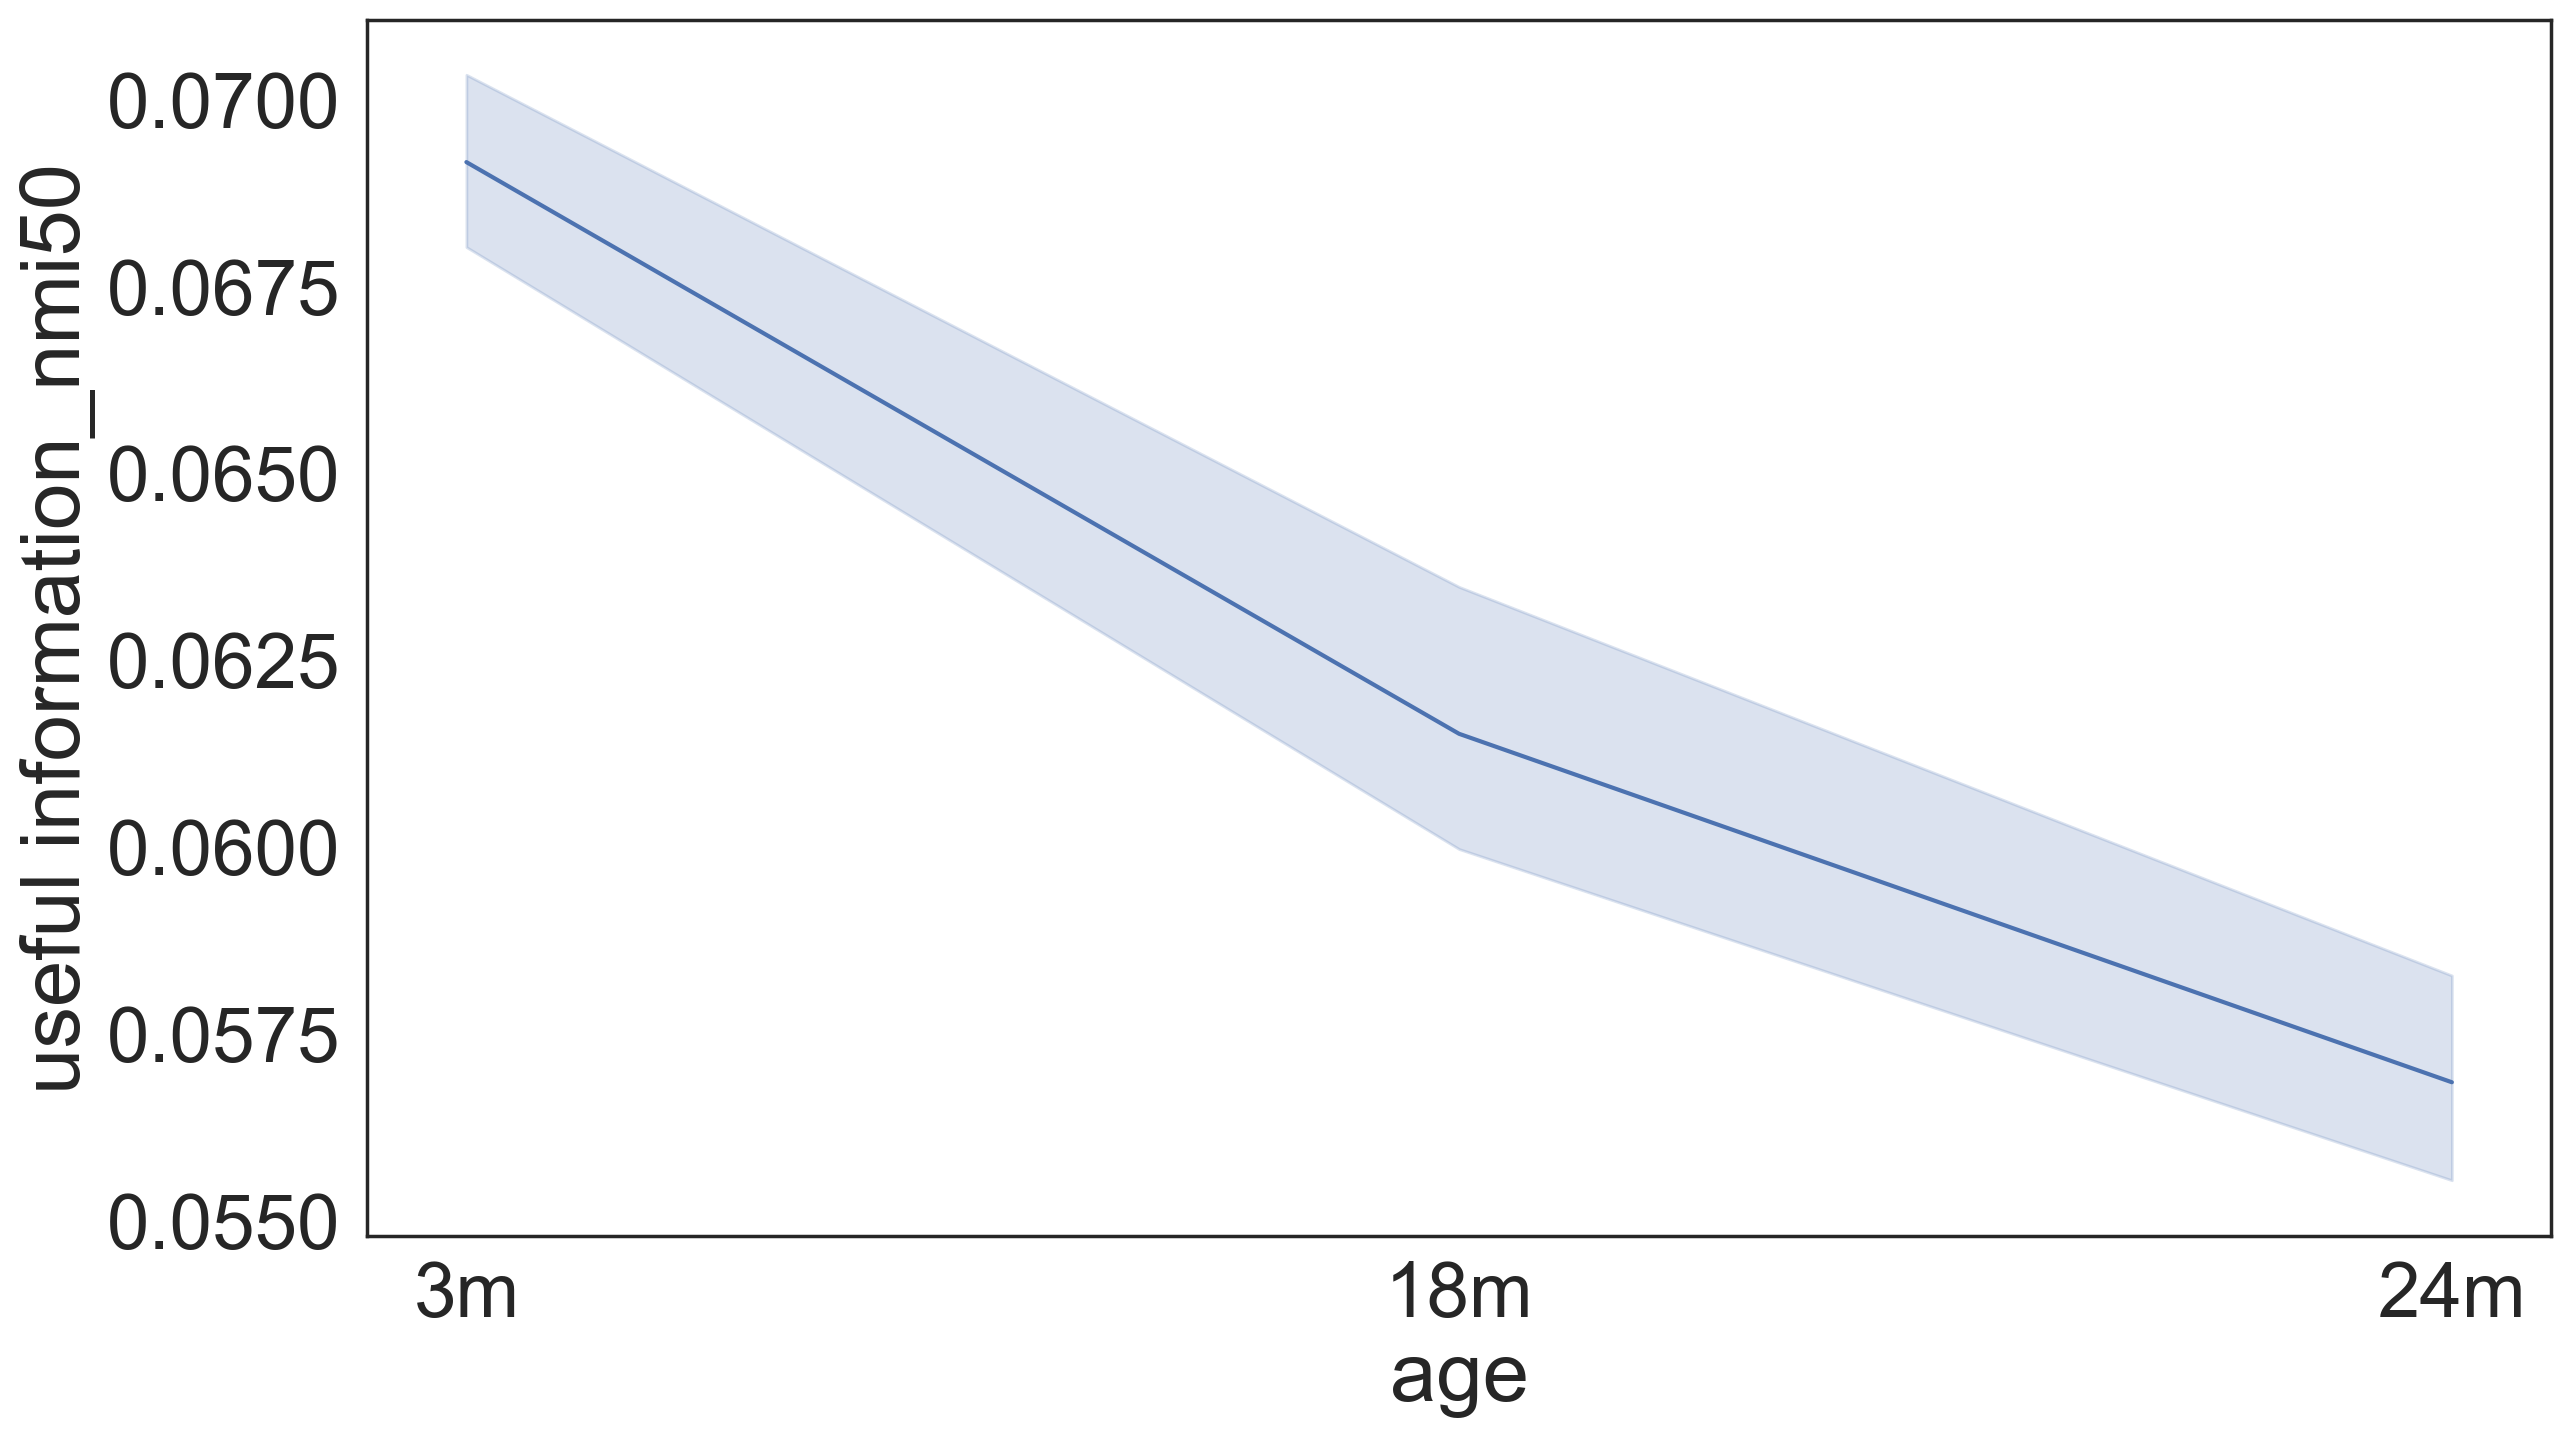

In [157]:
values_only_df['nmi_50']=nmi_50

sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

sns.lineplot(data=values_only_df, x='age',y='nmi_50')
plt.ylabel('useful information_nmi50')

Checking different bin widths for adjusted mutual information

In [132]:
def ami_500(df,present_tf_tg_dict):
    '''
    df: dataframe with genes as columns, cells as rows
    present_tf_tg_dict: dictionary of tf and tg - present pairs in the data
    ''' 
    
    ami_500=[]
    count=0
    
    for cellid, row in df.iterrows():
        
        #cell_tf=pd.cut(row[list(present_tf_tg_dict.keys())], bins=2**np.linspace(0, 15, 100)).sort_index()
        cell_tf=np.digitize(row[list(present_tf_tg_dict.keys())], bins=2**np.linspace(0, 15, 500),right=True)
        
        #cell_tg=pd.cut(row[list(present_tf_tg_dict.values())], bins=2**np.linspace(0, 15, 100)).sort_index()
        cell_tg=np.digitize(row[list(present_tf_tg_dict.values())], bins=2**np.linspace(0, 15, 500),right=True)
        
        try:
            ami_500.append(adjusted_mutual_info_score(cell_tf,cell_tg))
        except:
            count+=1
            
    return ami_500,count          

In [133]:
def ami_50(df,present_tf_tg_dict):
    '''
    df: dataframe with genes as columns, cells as rows
    present_tf_tg_dict: dictionary of tf and tg - present pairs in the data
    ''' 
    
    ami_50=[]
    count=0
    
    for cellid, row in df.iterrows():
        
        #cell_tf=pd.cut(row[list(present_tf_tg_dict.keys())], bins=2**np.linspace(0, 15, 100)).sort_index()
        cell_tf=np.digitize(row[list(present_tf_tg_dict.keys())], bins=2**np.linspace(0, 15, 50),right=True)
        
        #cell_tg=pd.cut(row[list(present_tf_tg_dict.values())], bins=2**np.linspace(0, 15, 100)).sort_index()
        cell_tg=np.digitize(row[list(present_tf_tg_dict.values())], bins=2**np.linspace(0, 15, 50),right=True)
        
        try:
            ami_50.append(adjusted_mutual_info_score(cell_tf,cell_tg))
        except:
            count+=1
            
    return ami_50,count    

In [137]:
values_only_df=(df).iloc[: , :-9]

In [138]:
ami_50,count = ami_50(values_only_df, present_tf_tg_dict)

In [139]:
ami_500,count = ami_500(values_only_df, present_tf_tg_dict)

Text(0, 0.5, 'useful information_ami500')

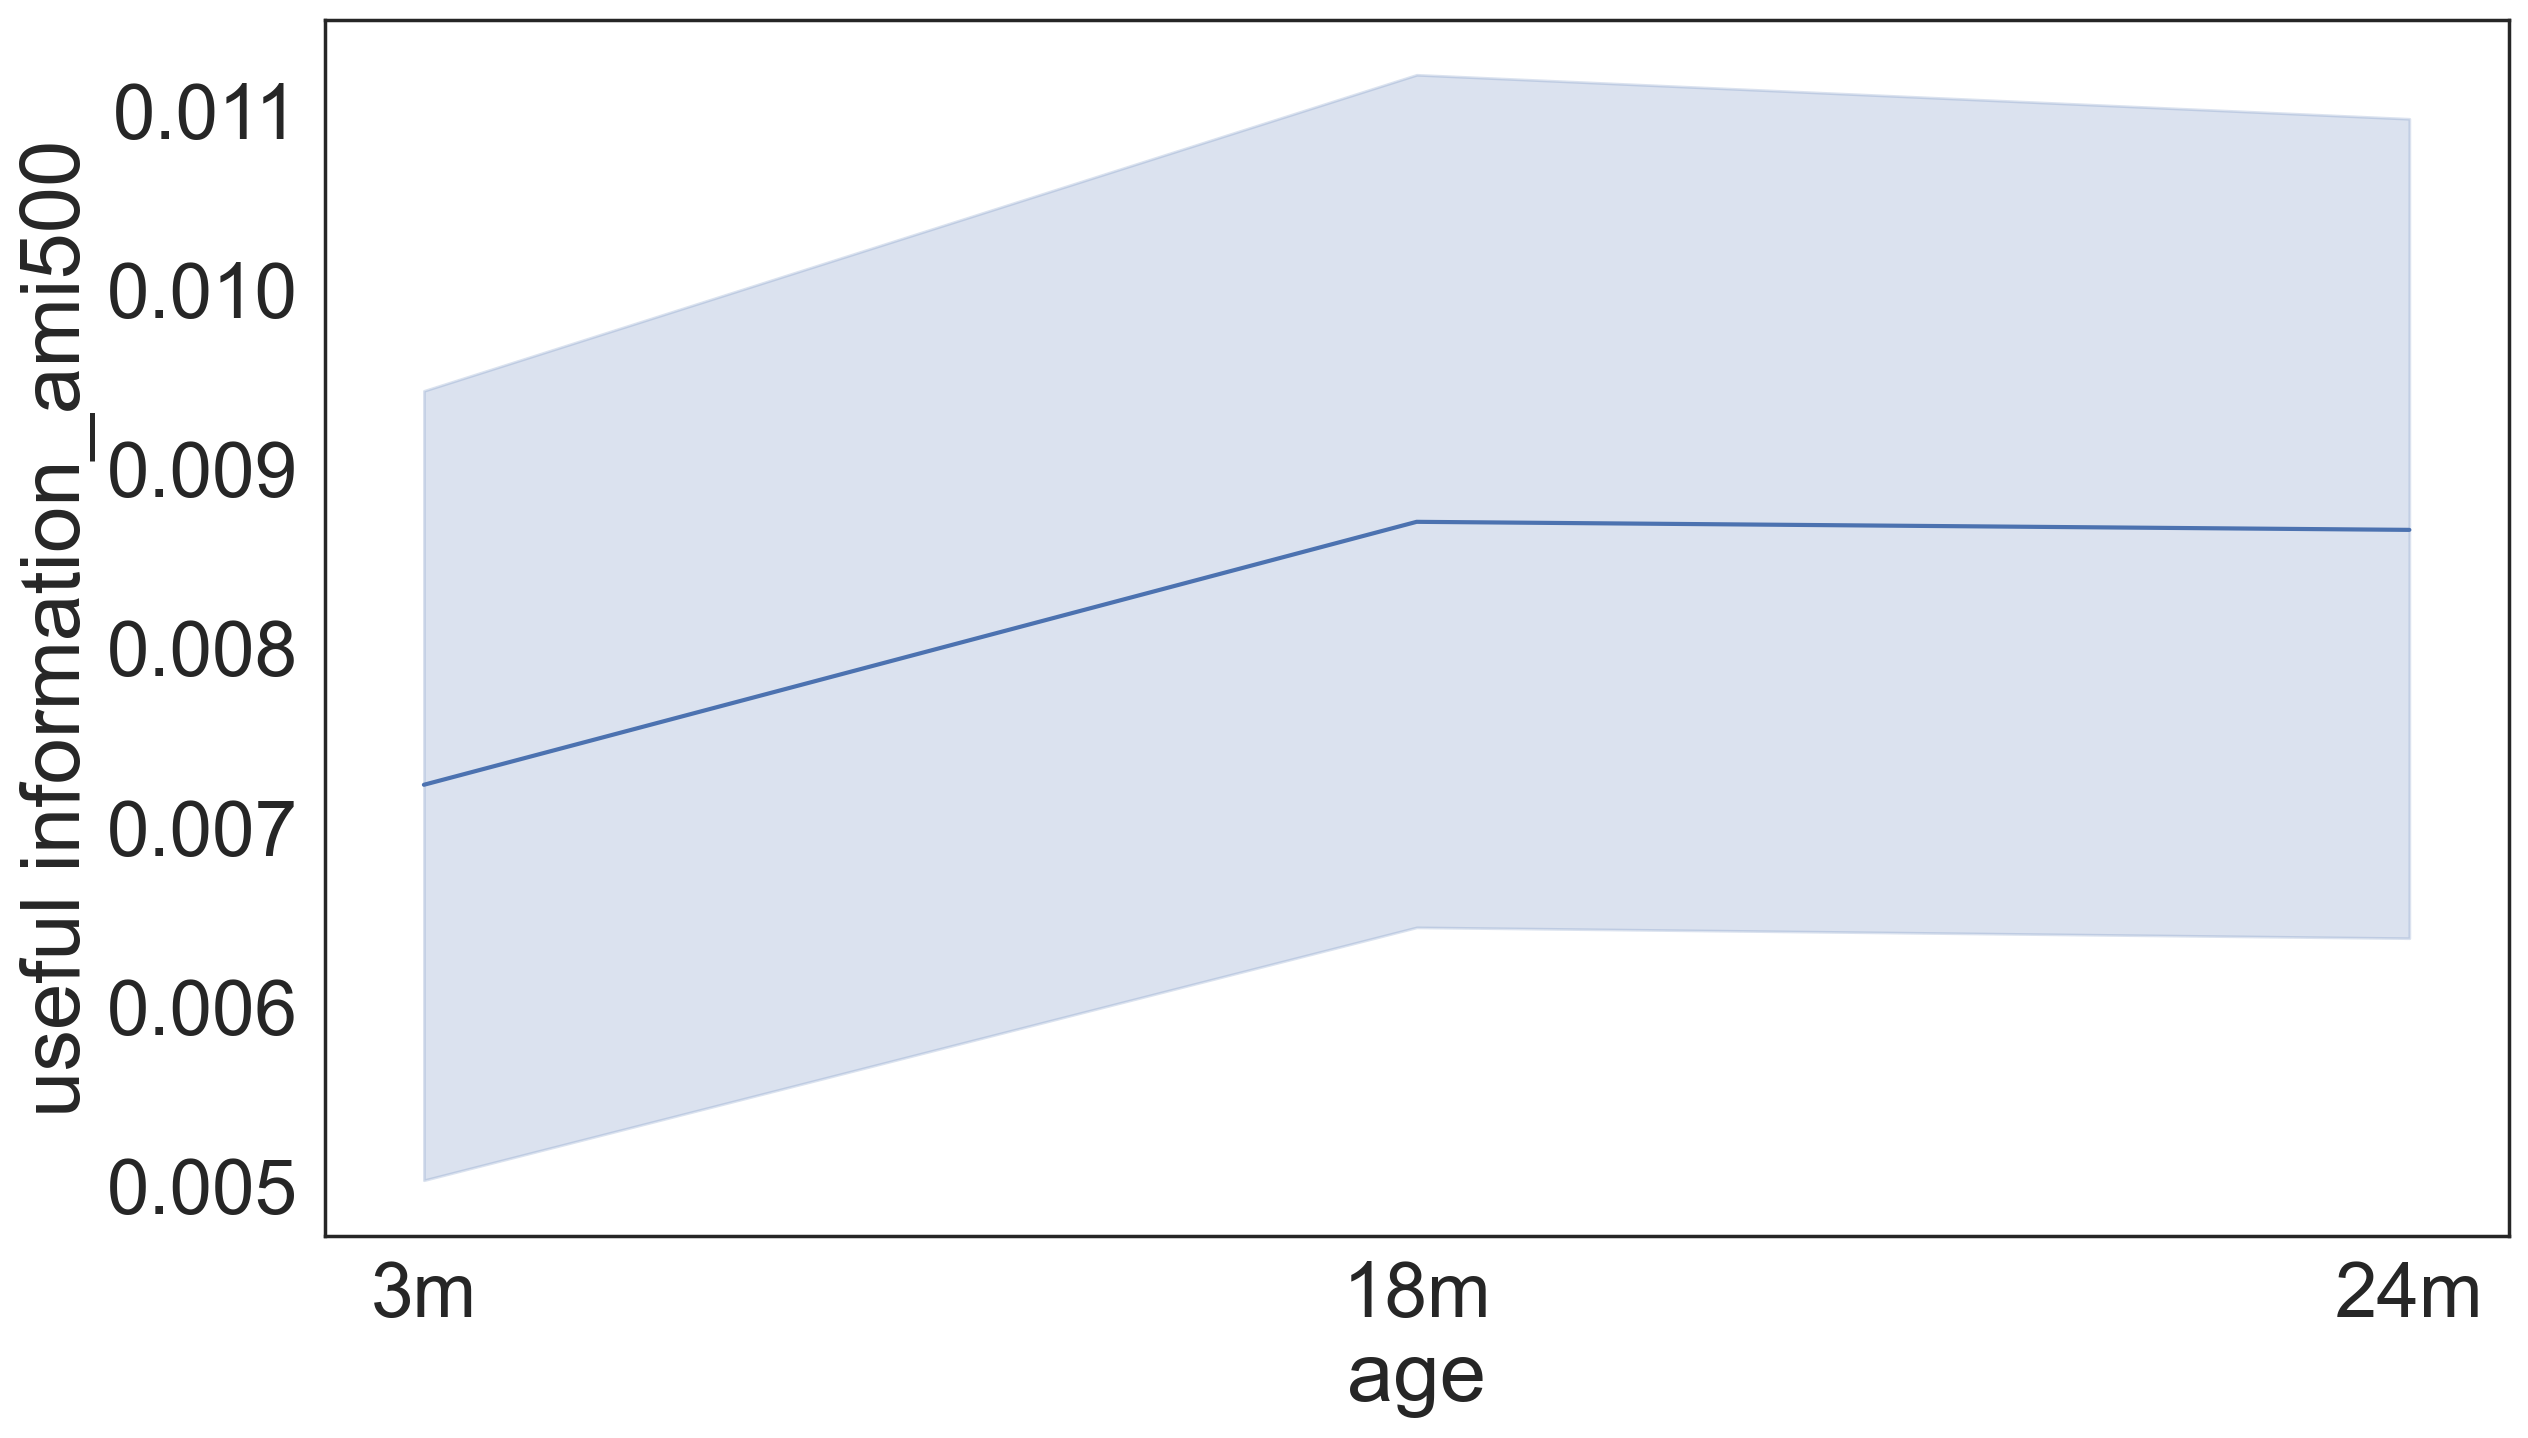

In [143]:
sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

values_only_df['ami_500']=ami_500
values_only_df['age']=df['age']
sns.lineplot(data=values_only_df, x='age',y='ami_500')
plt.ylabel('useful information_ami500')

Text(0, 0.5, 'useful information_ami50')

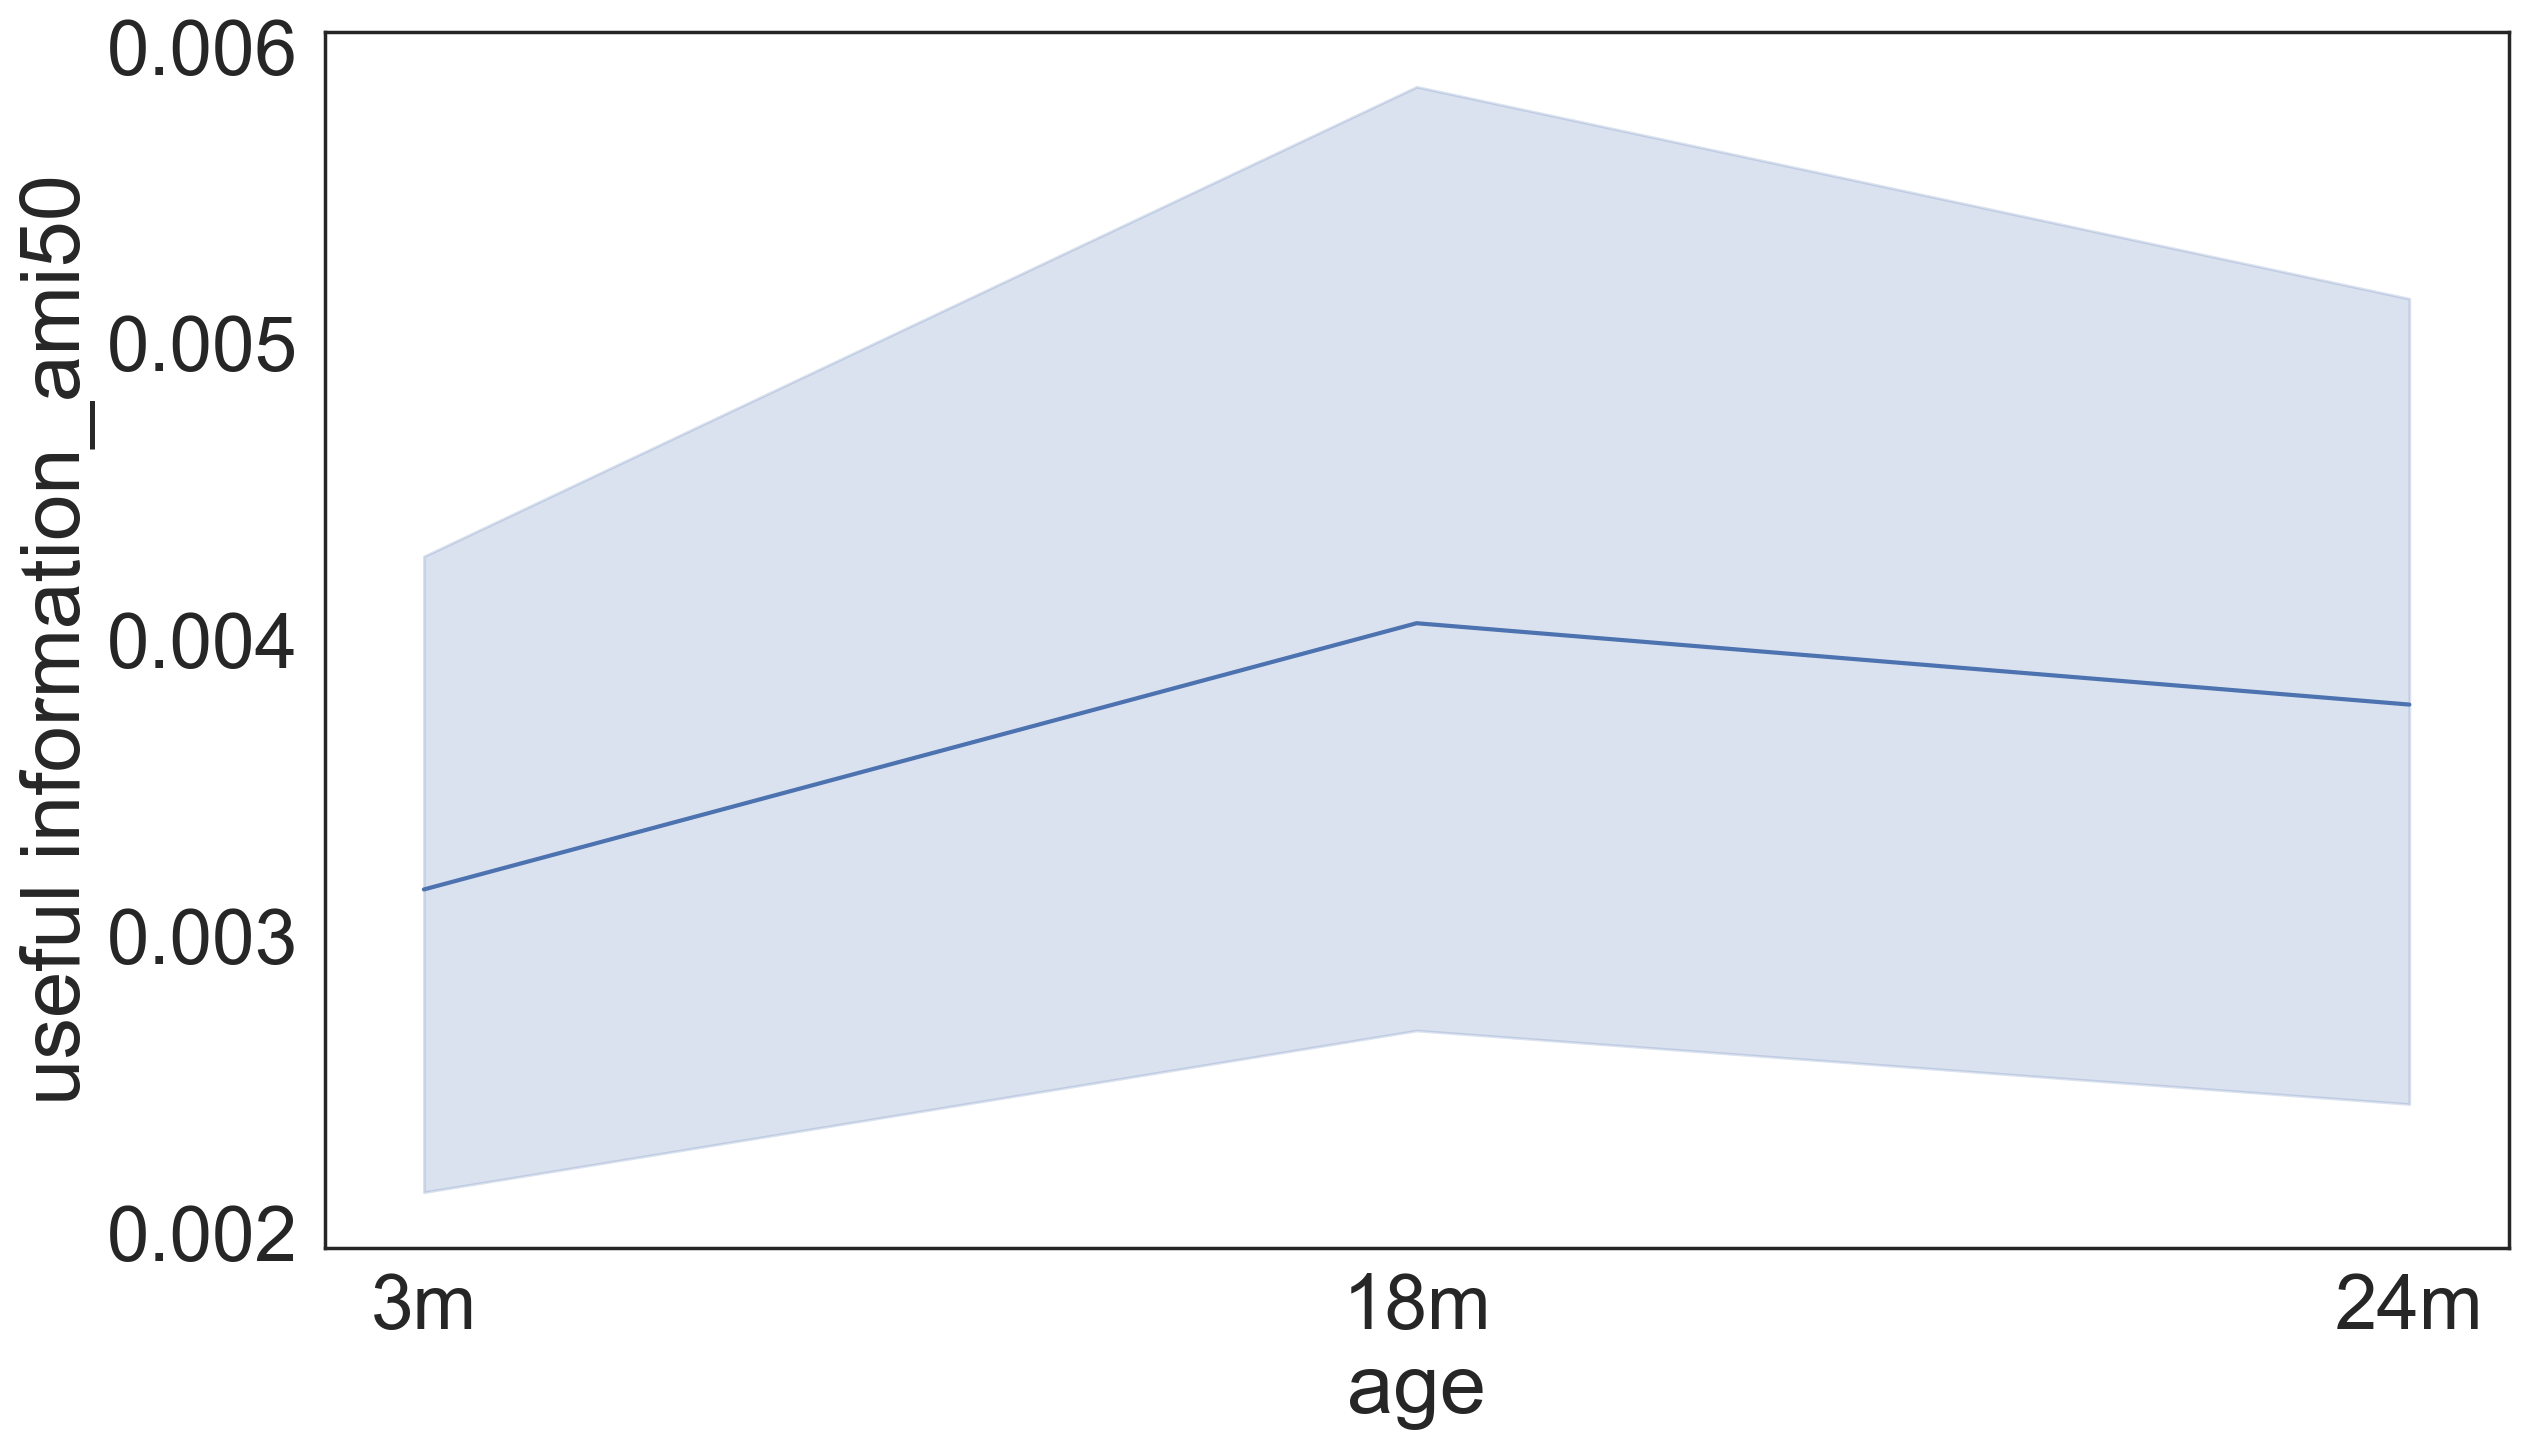

In [144]:
sns.set(font_scale = 2.5)
sns.set_style("white")
#plt.rcParams['patch.edgecolor'] = 'none'
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 22,'font.family':'sans-serif'})

values_only_df['ami_50']=ami_50
sns.lineplot(data=values_only_df, x='age',y='ami_50')
plt.ylabel('useful information_ami50')